In [1]:
import math
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import plotly.express as px
import plotly.figure_factory as ff
import plotly.graph_objects as go
import seaborn as sns
import statsmodels.stats.diagnostic as diag
import warnings

from imblearn.over_sampling import SMOTE

from lifelines import CoxPHFitter, KaplanMeierFitter, NelsonAalenFitter
from lifelines.statistics import logrank_test, proportional_hazard_test

from sklearn import metrics
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.inspection import permutation_importance
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score, recall_score, roc_auc_score, roc_curve, auc
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV,RepeatedKFold, RepeatedStratifiedKFold
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sksurv.nonparametric import kaplan_meier_estimator
from statistics import mean
from time import time as currentTime
from xgboost import XGBClassifier


warnings.filterwarnings('ignore') #ignoring all warning messages

## Exploratory Data Analysis

In [2]:
#Reading the dataset and printing the head
heart_df = pd.read_csv('heart_dataset.csv')
print("The dimensions of the dataset is:", heart_df.shape)
heart_df.head()

The dimensions of the dataset is: (299, 13)


age  anaemia  creatinine_phosphokinase  diabetes  ejection_fraction  \
0  75.0        0                       582         0                 20   
1  55.0        0                      7861         0                 38   
2  65.0        0                       146         0                 20   
3  50.0        1                       111         0                 20   
4  65.0        1                       160         1                 20   

   high_blood_pressure  platelets  serum_creatinine  serum_sodium  sex  \
0                    1  265000.00               1.9           130    1   
1                    0  263358.03               1.1           136    1   
2                    0  162000.00               1.3           129    1   
3                    0  210000.00               1.9           137    1   
4                    0  327000.00               2.7           116    0   

   smoking  time  DEATH_EVENT  
0        0     4            1  
1        0     6            1  
2        1     7            1  
3        0     7            1  
4        0     8            1

In [3]:
# Seeing the datatypes of each column, along with the non-null count
heart_df.info()
print("")
print(heart_df.isnull().sum())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 299 entries, 0 to 298
Data columns (total 13 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   age                       299 non-null    float64
 1   anaemia                   299 non-null    int64  
 2   creatinine_phosphokinase  299 non-null    int64  
 3   diabetes                  299 non-null    int64  
 4   ejection_fraction         299 non-null    int64  
 5   high_blood_pressure       299 non-null    int64  
 6   platelets                 299 non-null    float64
 7   serum_creatinine          299 non-null    float64
 8   serum_sodium              299 non-null    int64  
 9   sex                       299 non-null    int64  
 10  smoking                   299 non-null    int64  
 11  time                      299 non-null    int64  
 12  DEATH_EVENT               299 non-null    int64  
dtypes: float64(3), int64(10)
memory usage: 30.5 KB

age              

Luckily there are **no missing values** in our dataset.

In [4]:
# We could see that the columns **_['anaemia','diabetes','sex','smoking','high_blood_pressure']_** 
# contain a boolean value. These can be then changed into categorical values. 
# Two columns were renamed for enhancing readability.

heart_df['anaemia'] = pd.Categorical(heart_df.anaemia)
heart_df['diabetes'] = pd.Categorical(heart_df.diabetes)
heart_df['sex'] = pd.Categorical(heart_df.sex)
heart_df['smoking'] = pd.Categorical(heart_df.smoking)
heart_df['high_blood_pressure'] = pd.Categorical(heart_df.high_blood_pressure)

heart_df.rename(columns={"creatinine_phosphokinase":"CP","ejection_fraction":"EF"},inplace=True)

In [5]:
# Checking the datatypes of the columns once again.
# We can see that the datatypes of the aforementioned columns have changed from int64 into category.
heart_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 299 entries, 0 to 298
Data columns (total 13 columns):
 #   Column               Non-Null Count  Dtype   
---  ------               --------------  -----   
 0   age                  299 non-null    float64 
 1   anaemia              299 non-null    category
 2   CP                   299 non-null    int64   
 3   diabetes             299 non-null    category
 4   EF                   299 non-null    int64   
 5   high_blood_pressure  299 non-null    category
 6   platelets            299 non-null    float64 
 7   serum_creatinine     299 non-null    float64 
 8   serum_sodium         299 non-null    int64   
 9   sex                  299 non-null    category
 10  smoking              299 non-null    category
 11  time                 299 non-null    int64   
 12  DEATH_EVENT          299 non-null    int64   
dtypes: category(5), float64(3), int64(5)
memory usage: 20.9 KB


In [6]:
heart_df.describe(include='all') #describes the distribution of the features

age  anaemia           CP  diabetes          EF  \
count   299.000000    299.0   299.000000     299.0  299.000000   
unique         NaN      2.0          NaN       2.0         NaN   
top            NaN      0.0          NaN       0.0         NaN   
freq           NaN    170.0          NaN     174.0         NaN   
mean     60.833893      NaN   581.839465       NaN   38.083612   
std      11.894809      NaN   970.287881       NaN   11.834841   
min      40.000000      NaN    23.000000       NaN   14.000000   
25%      51.000000      NaN   116.500000       NaN   30.000000   
50%      60.000000      NaN   250.000000       NaN   38.000000   
75%      70.000000      NaN   582.000000       NaN   45.000000   
max      95.000000      NaN  7861.000000       NaN   80.000000   

        high_blood_pressure      platelets  serum_creatinine  serum_sodium  \
count                 299.0     299.000000         299.00000    299.000000   
unique                  2.0            NaN               NaN           NaN   
top                     0.0            NaN               NaN           NaN   
freq                  194.0            NaN               NaN           NaN   
mean                    NaN  263358.029264           1.39388    136.625418   
std                     NaN   97804.236869           1.03451      4.412477   
min                     NaN   25100.000000           0.50000    113.000000   
25%                     NaN  212500.000000           0.90000    134.000000   
50%                     NaN  262000.000000           1.10000    137.000000   
75%                     NaN  303500.000000           1.40000    140.000000   
max                     NaN  850000.000000           9.40000    148.000000   

          sex  smoking        time  DEATH_EVENT  
count   299.0    299.0  299.000000    299.00000  
unique    2.0      2.0         NaN          NaN  
top       1.0      0.0         NaN          NaN  
freq    194.0    203.0         NaN          NaN  
mean      NaN      NaN  130.260870      0.32107  
std       NaN      NaN   77.614208      0.46767  
min       NaN      NaN    4.000000      0.00000  
25%       NaN      NaN   73.000000      0.00000  
50%       NaN      NaN  115.000000      0.00000  
75%       NaN      NaN  203.000000      1.00000  
max       NaN      NaN  285.000000      1.00000

## Exploratory Data Analysis

In [7]:
fig = px.scatter(heart_df, y= "age", x="time", marginal_x="histogram", marginal_y="rug", color="DEATH_EVENT",
                 color_continuous_scale=["green", "red"])
fig.update_layout(title_text="Time vs Age")
fig.show()

In [8]:
fig = px.scatter(heart_df, x="age", y="time", color="DEATH_EVENT",facet_col="DEATH_EVENT",marginal_x="histogram",
                 color_continuous_scale=["green", "red"])
fig.update_layout(title_text = 'Age vs Time: For Dead and Survived Patients')
fig.show()

In [9]:
fig = px.scatter(heart_df, x="time", y="age",  color="DEATH_EVENT",facet_col="DEATH_EVENT",marginal_x="histogram",
                 trendline="ols",color_continuous_scale=["green", "red"])
fig.show()

In [10]:
fig = px.bar(heart_df,x="sex", color='sex',title='Discrete sex count',text_auto=True)
#fig.update_traces(textfont_size=12, textangle=0, textposition="outside", cliponaxis=False)
fig.show()

### Numerical features

In [11]:
#The histogram for age is plotted, with the dead and survived patients shown distinctly.

fig = px.histogram(heart_df, x = 'age', nbins = 20, text_auto=True,color='DEATH_EVENT',marginal="box",
                   color_discrete_sequence=['lightcoral','pink'], title='Histogram of Age')
fig.show()

<AxesSubplot:xlabel='age', ylabel='Count'>

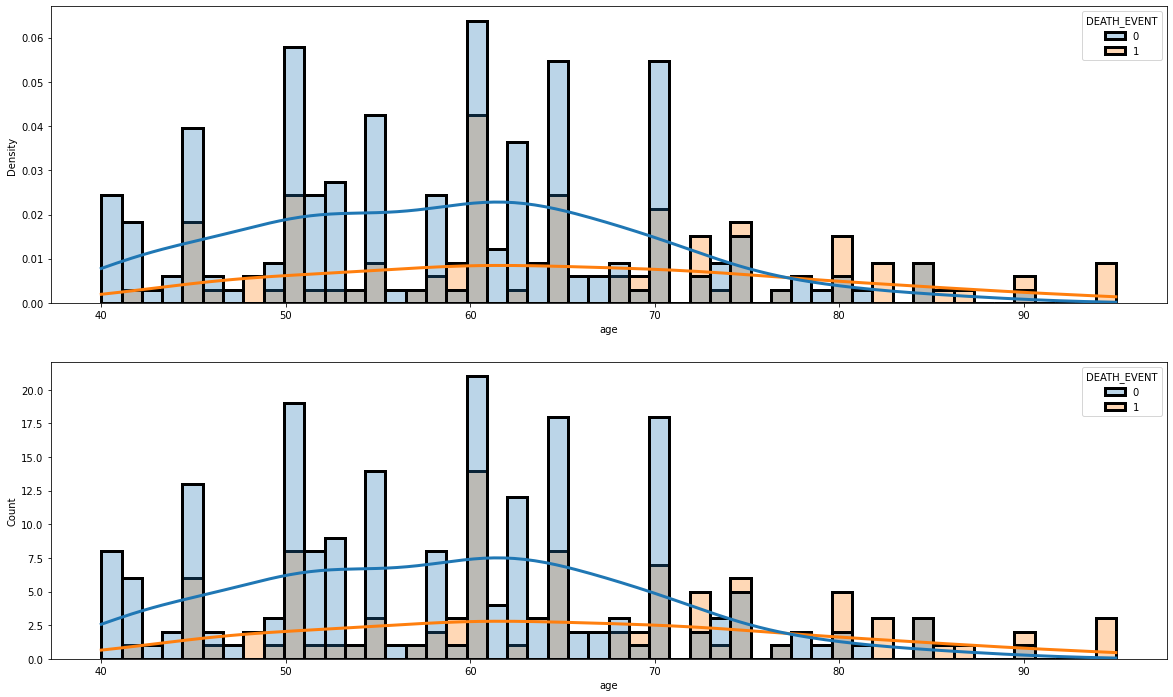

In [12]:
#The KDE plot for age is shown here.

hist_data = [heart_df['age']]
group_labels = ['age']
fig = ff.create_distplot(hist_data, group_labels, colors=['darkred'])
fig.show()

fid, ax = plt.subplots(2, 1, figsize = (20, 12))
sns.histplot(heart_df, x = 'age', hue = 'DEATH_EVENT', ax = ax[0], kde=True, bins = 50,
             stat = 'density', alpha = 0.3, legend = True, edgecolor = 'black',
             linewidth = 3, line_kws= {'linewidth': 3})

sns.histplot(heart_df, x = 'age', hue = 'DEATH_EVENT', ax = ax[1], kde=True, 
             common_norm = False, bins = 50, edgecolor = 'black', alpha = 0.3, 
             legend = True, linewidth = 3, line_kws= {'linewidth': 3})


In [13]:
#The histogram for CP, with the dead and survived patients shown distinctly.

fig = px.histogram(heart_df, x = 'CP', nbins = 15, text_auto=True,color='DEATH_EVENT',marginal="box",
                   color_discrete_sequence=['lightcoral','pink'],  title='Histogram of Creatinine Phosphokinase')
fig.show()

In [14]:
#The histogram for ejection fraction, with the dead and survived patients shown distinctly.

fig = px.histogram(heart_df, x = 'EF', nbins = 15, text_auto=True,color='DEATH_EVENT',marginal="box",
                   color_discrete_sequence=['lightcoral','pink'], title='Histogram of Ejection Fraction')
fig.show()

In [15]:
#The histogram for platelets, with the dead and survived patients shown distinctly.

fig = px.histogram(heart_df, x = 'platelets', nbins = 15, text_auto=True,color='DEATH_EVENT',marginal="box",
                   color_discrete_sequence=['lightcoral','pink'], title='Histogram of Platelets')
fig.show()

In [16]:
#The histogram for serum creatinine, with the dead and survived patients shown distinctly.

fig = px.histogram(heart_df, x = 'serum_creatinine', nbins = 15, text_auto=True,color='DEATH_EVENT',marginal="box",
                   color_discrete_sequence=['lightcoral','pink'], title='Histogram of Serum Creatinine')
fig.show()

In [17]:
#The histogram for serum sodium, with the dead and survived patients shown distinctly.

fig = px.histogram(heart_df, x = 'serum_sodium', nbins = 15, text_auto=True,color='DEATH_EVENT',marginal="box",
                   color_discrete_sequence=['lightcoral','pink'], title='Histogram of Serum Sodium')
fig.show()

In [18]:
#The histogram for time, with the dead and survived patients shown distinctly.

fig = px.histogram(heart_df, x = 'time', nbins = 15, text_auto=True,color='DEATH_EVENT',marginal="box",
                   color_discrete_sequence=['lightcoral','pink'], title='Histogram of Time')
fig.show()

### Categorical Features

In [19]:
# The proportion of patients with and without anaemia is shown in the first graph.
# The second graph shows the proportion of anaemic patients who died and survived from heart failure.
# The third graph is a depiction of the proportion of the non-anaemic patients who died and survived from heart failure.

fig = px.pie(heart_df, names = 'anaemia', title='Proportion of patients who had Anaemia:', 
             color_discrete_sequence = ['royalblue','orange'])
fig.update_traces(textinfo='value+percent')
fig.show()
fig1 = px.pie(heart_df[heart_df['anaemia']==1], names='DEATH_EVENT', 
              color_discrete_sequence=['royalblue','orange'], title='Survival % of patients who had Anaemia:')
fig1.update_traces(textinfo='value+percent')
fig1.show()
fig2 = px.pie(heart_df[heart_df['anaemia']==0], names='DEATH_EVENT', 
              color_discrete_sequence=['royalblue','orange'], title='Survival % of patients who did not have Anaemia:')
fig2.update_traces(textinfo='value+percent')
fig2.show()

In [20]:
# The proportion of patients with and without diabetes is shown in the first graph.
# The second graph shows the proportion of diabetic patients who died and survived from heart failure.
# The third graph is a depiction of the proportion of the non-diabetic patients who died and survived from heart failure.

fig = px.pie(heart_df, names = 'diabetes', title='Proportion of patients who had diabetes:', 
             color_discrete_sequence = ['royalblue','orange'])
fig.update_traces(textinfo='value+percent')
fig.show()
fig1 = px.pie(heart_df[heart_df['diabetes']==1], names='DEATH_EVENT', 
              color_discrete_sequence=['royalblue','orange'], title='Survival % of patients who had diabetes:')
fig1.update_traces(textinfo='value+percent')
fig1.show()
fig2 = px.pie(heart_df[heart_df['diabetes']==0], names='DEATH_EVENT', 
              color_discrete_sequence=['royalblue','orange'], title='Survival % of patients who did not have diabetes:')
fig2.update_traces(textinfo='value+percent')
fig2.show()

In [21]:
# The proportion of patients with and without diabetes is shown in the first graph.
# The second graph shows the proportion of diabetic patients who died and survived from heart failure.
# The third graph is a depiction of the proportion of the non-diabetic patients who died and survived from heart failure.

fig = px.pie(heart_df, names = 'high_blood_pressure', title='Proportion of patients who had high BP:', 
             color_discrete_sequence = ['royalblue','orange'])
fig.update_traces(textinfo='value+percent')
fig.show()
fig1 = px.pie(heart_df[heart_df['high_blood_pressure']==1], names='DEATH_EVENT', 
              color_discrete_sequence=['royalblue','orange'], title='Survival % of patients who had high BP:')
fig1.update_traces(textinfo='value+percent')
fig1.show()
fig2 = px.pie(heart_df[heart_df['high_blood_pressure']==0], names='DEATH_EVENT', 
              color_discrete_sequence=['royalblue','orange'], title='Survival % of patients who did not have high BP:')
fig2.update_traces(textinfo='value+percent')
fig2.show()

In [22]:
# The proportion of patients by sex is shown in the first graph.
# The second graph shows the proportion of male patients who died and survived from heart failure.
# The third graph is a depiction of the proportion of the female patients who died and survived from heart failure.

fig = px.pie(heart_df, names = 'sex', title='Proportion of patients by sex:', 
             color_discrete_sequence = ['royalblue','orange'])
fig.update_traces(textinfo='value+percent')
fig.show()
fig1 = px.pie(heart_df[heart_df['sex']==1], names='DEATH_EVENT', 
              color_discrete_sequence=['royalblue','orange'], title='Survival % of male patients:')
fig1.update_traces(textinfo='value+percent')
fig1.show()
fig2 = px.pie(heart_df[heart_df['sex']==0], names='DEATH_EVENT', 
              color_discrete_sequence=['royalblue','orange'], title='Survival % of female patients:')
fig2.update_traces(textinfo='value+percent')
fig2.show()

In [23]:
# The proportion of patients by smoking habits is shown in the first graph.
# The second graph shows the proportion of smoking patients who died and survived from heart failure.
# The third graph is a depiction of the proportion of the non-smoking patients who died and survived from heart failure.

fig = px.pie(heart_df, names = 'smoking', title='Proportion of patients who smoke:', 
             color_discrete_sequence = ['royalblue','orange'])
fig.update_traces(textinfo='value+percent')
fig.show()
fig1 = px.pie(heart_df[heart_df['smoking']==1], names='DEATH_EVENT', 
              color_discrete_sequence=['royalblue','orange'], title='Survival % of smokers:')
fig1.update_traces(textinfo='value+percent')
fig1.show()
fig2 = px.pie(heart_df[heart_df['smoking']==0], names='DEATH_EVENT', 
              color_discrete_sequence=['royalblue','orange'], title='Survival % of non-smokers:')
fig2.update_traces(textinfo='value+percent')
fig2.show()

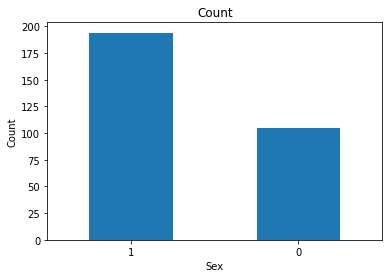

In [24]:
heart_df.sex.value_counts().plot(kind="bar",
                           title="Count",
                           rot=0, #rotate the axis
                           xlabel="Sex",
                           ylabel="Count");

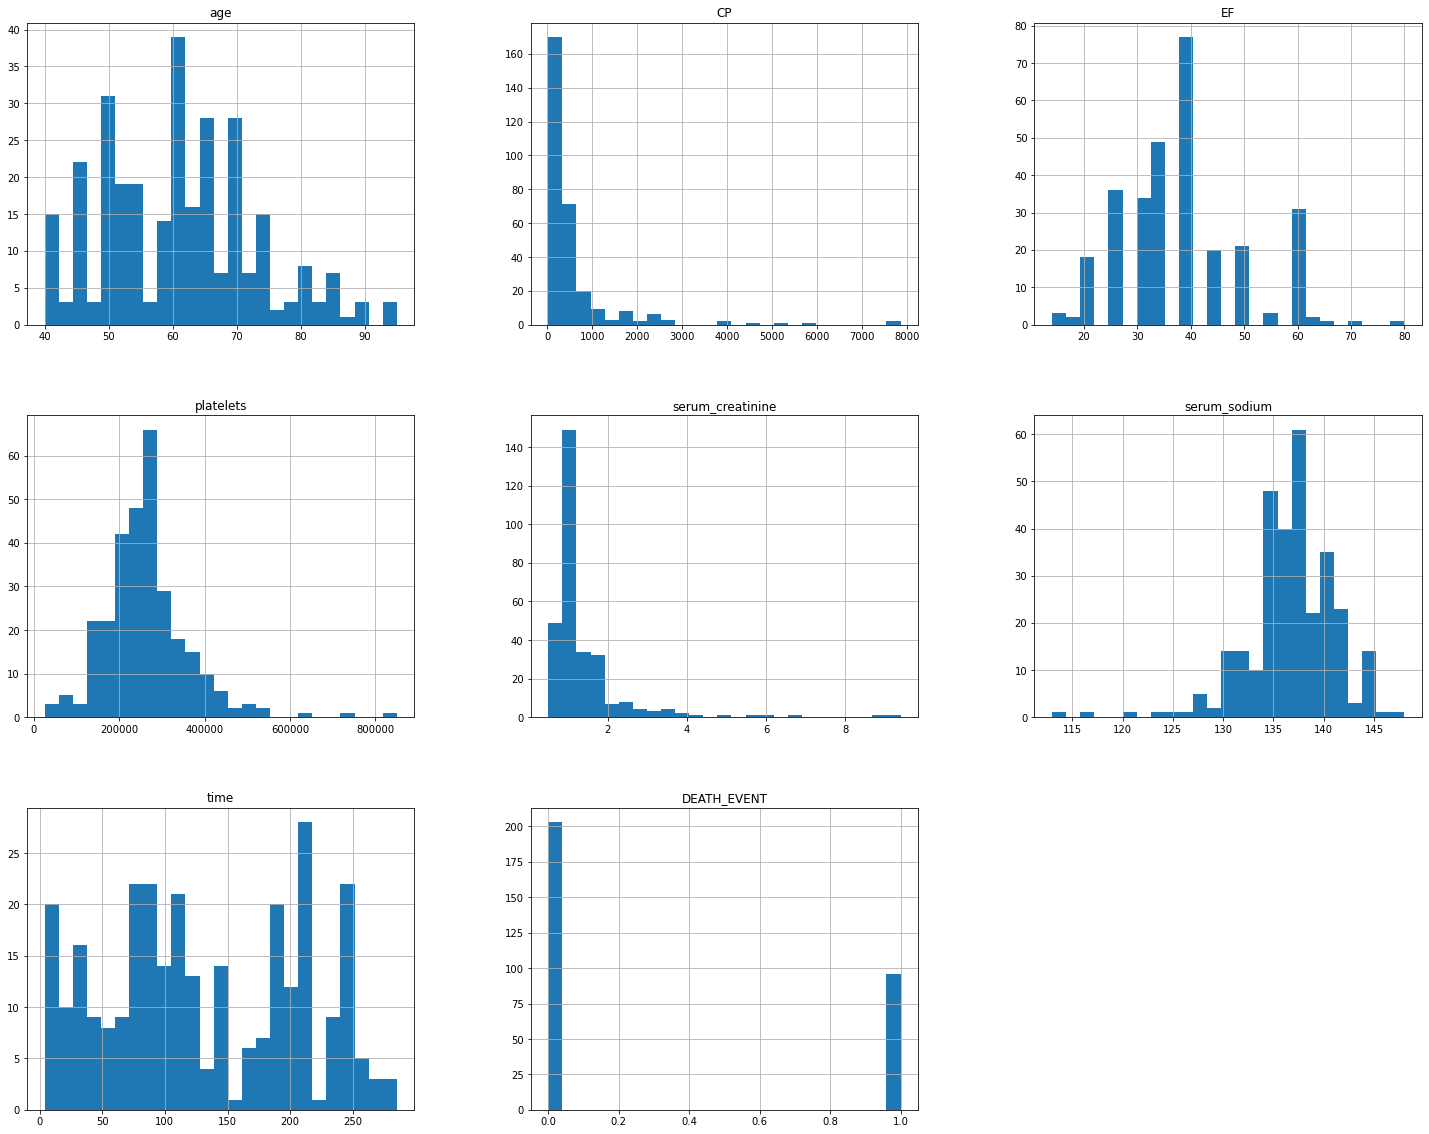

In [25]:
#Histograms are plotted for all the numerical features, along with time and DEATH_EVENT.
heart_df.hist(bins = 25,figsize=(25,20));

## Correlation Matrix

In [26]:
# The correlation matrix is displayed here. It gives an idea of how various features are related to one another.
cormatrix = heart_df.corr()
cormatrix

age        CP        EF  platelets  serum_creatinine  \
age               1.000000 -0.081584  0.060098  -0.052354          0.159187   
CP               -0.081584  1.000000 -0.044080   0.024463         -0.016408   
EF                0.060098 -0.044080  1.000000   0.072177         -0.011302   
platelets        -0.052354  0.024463  0.072177   1.000000         -0.041198   
serum_creatinine  0.159187 -0.016408 -0.011302  -0.041198          1.000000   
serum_sodium     -0.045966  0.059550  0.175902   0.062125         -0.189095   
time             -0.224068 -0.009346  0.041729   0.010514         -0.149315   
DEATH_EVENT       0.253729  0.062728 -0.268603  -0.049139          0.294278   

                  serum_sodium      time  DEATH_EVENT  
age                  -0.045966 -0.224068     0.253729  
CP                    0.059550 -0.009346     0.062728  
EF                    0.175902  0.041729    -0.268603  
platelets             0.062125  0.010514    -0.049139  
serum_creatinine     -0.189095 -0.149315     0.294278  
serum_sodium          1.000000  0.087640    -0.195204  
time                  0.087640  1.000000    -0.526964  
DEATH_EVENT          -0.195204 -0.526964     1.000000

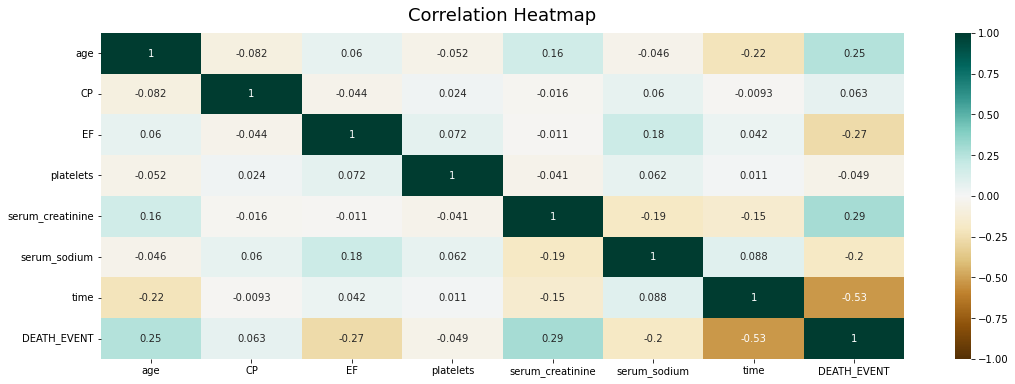

In [27]:
# The correlation matrix is visualised for quick inferences.
plt.figure(figsize=(18, 6))
heatmap = sns.heatmap(cormatrix, vmin=-1, annot=True, cmap='BrBG')
heatmap.set_title('Correlation Heatmap', fontdict={'fontsize':18}, pad=12);
plt.savefig('D:/UoL Study Material/Dissertation/Pictures/heatmap.png', dpi = 450)

We could identify the following relations the target variable DEATH_EVENT has with other features from the correlation matrix:

- **Negative correlation of -0.53 with follow up time.**
- **Negative correlation of -0.27 with Ejection Fraction.**
- **Positive correlation of 0.29 with Serum Creatinine.**
- **Positive correlation of 0.25 with the age of the patient.**

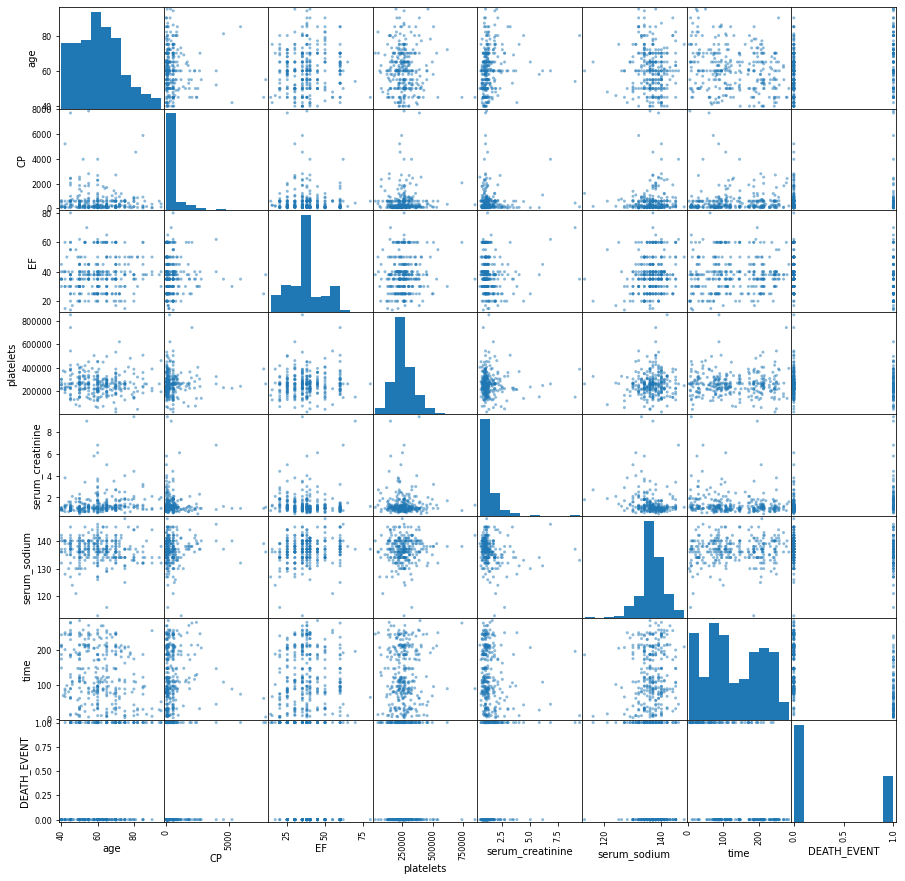

In [28]:
pd.plotting.scatter_matrix(heart_df, figsize=(15,15));

### Boxplot

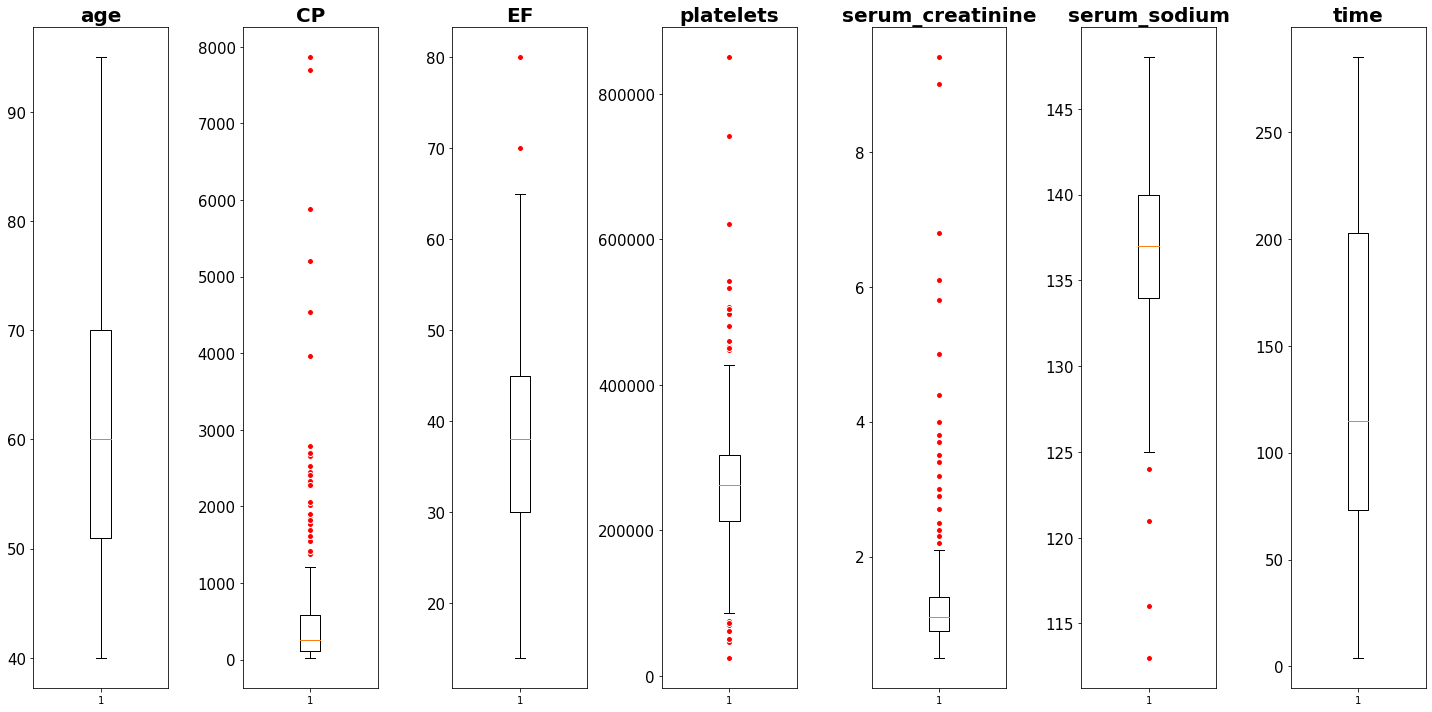

In [29]:
# Plotting boxplots to check for potential outliers
columns = ['age', 'CP', 'EF', 'platelets', 'serum_creatinine', 'serum_sodium', 'time']

#Creating subplot of each column with its own scale
red_circle = dict(markerfacecolor='red', marker='o', markeredgecolor='white') #the outliers are marked with a red circle
fig, axs = plt.subplots(1, len(columns), figsize=(20,10))

for i, ax in enumerate(axs.flat):
    ax.boxplot(heart_df[columns[i]], flierprops=red_circle)
    ax.set_title(columns[i], fontsize=20, fontweight='bold')
    ax.tick_params(axis='y', labelsize=15)
    
plt.tight_layout()
plt.savefig('D:/UoL Study Material/Dissertation/Pictures/boxplot.png', dpi = 450)

### Survival Analysis

In [30]:
#Creating a copy of the original dataframe, as we are about to add new columns for creating bins.
survival_heart_df = heart_df.copy(deep=True) 
survival_heart_df

age anaemia    CP diabetes  EF high_blood_pressure  platelets  \
0    75.0       0   582        0  20                   1  265000.00   
1    55.0       0  7861        0  38                   0  263358.03   
2    65.0       0   146        0  20                   0  162000.00   
3    50.0       1   111        0  20                   0  210000.00   
4    65.0       1   160        1  20                   0  327000.00   
..    ...     ...   ...      ...  ..                 ...        ...   
294  62.0       0    61        1  38                   1  155000.00   
295  55.0       0  1820        0  38                   0  270000.00   
296  45.0       0  2060        1  60                   0  742000.00   
297  45.0       0  2413        0  38                   0  140000.00   
298  50.0       0   196        0  45                   0  395000.00   

     serum_creatinine  serum_sodium sex smoking  time  DEATH_EVENT  
0                 1.9           130   1       0     4            1  
1                 1.1           136   1       0     6            1  
2                 1.3           129   1       1     7            1  
3                 1.9           137   1       0     7            1  
4                 2.7           116   0       0     8            1  
..                ...           ...  ..     ...   ...          ...  
294               1.1           143   1       1   270            0  
295               1.2           139   0       0   271            0  
296               0.8           138   0       0   278            0  
297               1.4           140   1       1   280            0  
298               1.6           136   1       1   285            0  

[299 rows x 13 columns]

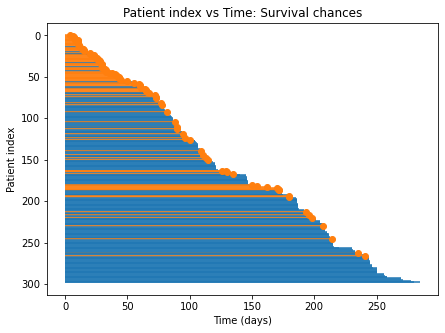

In [31]:
# Survival Analysis
plt.figure(figsize=(7,5))
def plot_lifelines(survival_heart_df):
    """Plot a line for each observation."""
    for y, row in survival_heart_df.iterrows():
        start = 0
        end = row['time']
        status = row['DEATH_EVENT']
        
        if status == 0:
            # censored records
            plt.hlines(y, start, end, color='C0', label='Censored')
        else:
            # subjects experienced the event of interest
            plt.hlines(y, start, end, color='C1')
            plt.plot(end, y, marker='o', color='C1',label='Dead')
            
    plt.xlabel('Time (days)')
    plt.ylabel('Patient index')
    plt.title('Patient index vs Time: Survival chances')
    plt.gca().invert_yaxis()
    plt.savefig('D:/UoL Study Material/Dissertation/Pictures/surv_summary.png', dpi = 450)
    plt.show()
    
plot_lifelines(heart_df)

In [32]:
#creating a new boolean column 'died'.
survival_heart_df['died'] = survival_heart_df['DEATH_EVENT'].astype(bool)
survival_heart_df

age anaemia    CP diabetes  EF high_blood_pressure  platelets  \
0    75.0       0   582        0  20                   1  265000.00   
1    55.0       0  7861        0  38                   0  263358.03   
2    65.0       0   146        0  20                   0  162000.00   
3    50.0       1   111        0  20                   0  210000.00   
4    65.0       1   160        1  20                   0  327000.00   
..    ...     ...   ...      ...  ..                 ...        ...   
294  62.0       0    61        1  38                   1  155000.00   
295  55.0       0  1820        0  38                   0  270000.00   
296  45.0       0  2060        1  60                   0  742000.00   
297  45.0       0  2413        0  38                   0  140000.00   
298  50.0       0   196        0  45                   0  395000.00   

     serum_creatinine  serum_sodium sex smoking  time  DEATH_EVENT   died  
0                 1.9           130   1       0     4            1   True  
1                 1.1           136   1       0     6            1   True  
2                 1.3           129   1       1     7            1   True  
3                 1.9           137   1       0     7            1   True  
4                 2.7           116   0       0     8            1   True  
..                ...           ...  ..     ...   ...          ...    ...  
294               1.1           143   1       1   270            0  False  
295               1.2           139   0       0   271            0  False  
296               0.8           138   0       0   278            0  False  
297               1.4           140   1       1   280            0  False  
298               1.6           136   1       1   285            0  False  

[299 rows x 14 columns]

### Kaplan-Meier Estimator

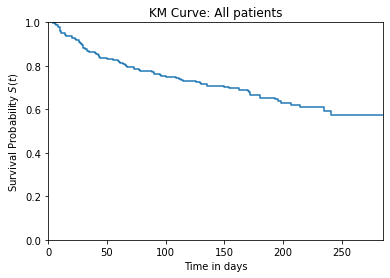

In [33]:
#sp represents the survival probability
time, sp = kaplan_meier_estimator(survival_heart_df['died'], survival_heart_df['time'])
plt.step(time, sp, where="post")
plt.xlabel('Time in days')
plt.ylabel('Survival Probability $S(t)$')
plt.axis((0, max(survival_heart_df['time']), 0, 1.0))
plt.title('KM Curve: All patients')
plt.savefig("D:/UoL Study Material/Dissertation/Pictures/general_survival.png", dpi = 450)
plt.show()

In [34]:
print("Survival Probability after the first event occurence:", round(sp[0]*100, 2), "% on Day", time[0])
print("Survival Probability after the last event occurence:", round(sp[len(sp)-1]*100,2), "% on Day", time[len(time)-1])

Survival Probability after the first event occurence: 99.67 % on Day 4
Survival Probability after the last event occurence: 57.57 % on Day 285


#### Anaemia

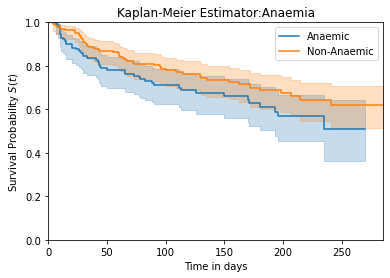

In [35]:
y1 = survival_heart_df.query('anaemia==1')   #stores all the patients who have anaemia
n1 = survival_heart_df.query('anaemia==0')   #stores all the patients who do not suffer from anaemia

kmf_y = KaplanMeierFitter()
kmf_n = KaplanMeierFitter()
kmf_y.fit(y1['time'], y1['DEATH_EVENT'], label ='Anaemic')
kmf_y.plot()

kmf_n.fit(n1['time'], n1['DEATH_EVENT'], label ='Non-Anaemic')
kmf_n.plot()

plt.xlabel('Time in days')
plt.ylabel('Survival Probability $S(t)$')
plt.legend(loc="best")
plt.title("Kaplan-Meier Estimator:Anaemia")
plt.axis((0, max(survival_heart_df['time']), 0, 1.0));
plt.savefig("D:/UoL Study Material/Dissertation/Pictures/surv_anaemia.png", dpi = 450)
plt.show()

In [36]:
kmf_n.predict(232) #Tells the survival probability of a non-anaemic patient on day 232.

0.6433192312949374

In [37]:
#Used to see the median survival time. Since the survival probability does not go below 0.5, it is shown as inf.
kmf_y.median_survival_time_ 

inf

In [38]:
#The survival probability associated with an anaemic patient on each day of event occurence.
kmf_y.survival_function_

Anaemic
timeline          
0.0       1.000000
7.0       0.992248
8.0       0.976744
10.0      0.945736
11.0      0.930233
...            ...
245.0     0.511037
246.0     0.511037
250.0     0.511037
256.0     0.511037
270.0     0.511037

[90 rows x 1 columns]

In [39]:
#The survival probability associated with a non-anaemic patient on each day of event occurence.
kmf_n.survival_function_

Non-Anaemic
timeline             
0.0          1.000000
4.0          0.994118
6.0          0.988235
7.0          0.982353
10.0         0.970588
...               ...
270.0        0.618576
271.0        0.618576
278.0        0.618576
280.0        0.618576
285.0        0.618576

[109 rows x 1 columns]

In [40]:
#Event table gives an idea about the number of subjects experiencing the event.
#event_at : The day of occurence of the event.
#removed  : The number of subjects removed from the study on that particular day.
#observed : The number of subjects which experienced the event on that day.
#censored : The number of subjects which were censored on that day.
#entrance : The number of subjects at the beginning of the study.
#at_risk  : The number of subjects at risk on that particular day.
kmf_y.event_table

removed  observed  censored  entrance  at_risk
event_at                                                
0.0             0         0         0       129      129
7.0             1         1         0         0      129
8.0             2         2         0         0      128
10.0            4         4         0         0      126
11.0            2         2         0         0      122
...           ...       ...       ...       ...      ...
245.0           1         0         1         0        6
246.0           1         0         1         0        5
250.0           2         0         2         0        4
256.0           1         0         1         0        2
270.0           1         0         1         0        1

[90 rows x 5 columns]

In [41]:
kmf_y.cumulative_density_ #The cumulative density of anaemic patients.

Anaemic
timeline          
0.0       0.000000
7.0       0.007752
8.0       0.023256
10.0      0.054264
11.0      0.069767
...            ...
245.0     0.488963
246.0     0.488963
250.0     0.488963
256.0     0.488963
270.0     0.488963

[90 rows x 1 columns]

In [42]:
kmf_n.cumulative_density_ #The cumulative density of non-anaemic patients.

Non-Anaemic
timeline             
0.0          0.000000
4.0          0.005882
6.0          0.011765
7.0          0.017647
10.0         0.029412
...               ...
270.0        0.381424
271.0        0.381424
278.0        0.381424
280.0        0.381424
285.0        0.381424

[109 rows x 1 columns]

<AxesSubplot:xlabel='timeline'>

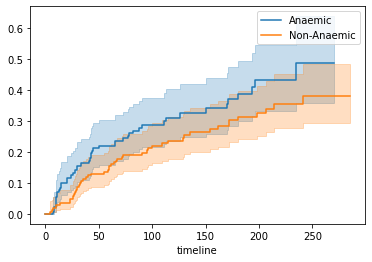

In [43]:
kmf_y.plot_cumulative_density()
kmf_n.plot_cumulative_density()

In [44]:
#Nelson-Aalen Estimate
naf_a = NelsonAalenFitter()
naf_na = NelsonAalenFitter()

naf_a.fit(y1['time'], event_observed=y1['DEATH_EVENT'], label='Anaemic')
naf_na.fit(n1['time'], event_observed=n1['DEATH_EVENT'], label='Non-Anaemic')

<lifelines.NelsonAalenFitter:"Non-Anaemic", fitted with 170 total observations, 120 right-censored observations>

In [45]:
print(naf_a.cumulative_hazard_)
print(naf_na.cumulative_hazard_)

           Anaemic
timeline          
0.0       0.000000
7.0       0.007752
8.0       0.023438
10.0      0.055570
11.0      0.072031
...            ...
245.0     0.661292
246.0     0.661292
250.0     0.661292
256.0     0.661292
270.0     0.661292

[90 rows x 1 columns]
          Non-Anaemic
timeline             
0.0          0.000000
4.0          0.005882
6.0          0.011800
7.0          0.017752
10.0         0.029764
...               ...
270.0        0.477173
271.0        0.477173
278.0        0.477173
280.0        0.477173
285.0        0.477173

[109 rows x 1 columns]


In [46]:
#Event table gives an idea about the number of subjects experiencing the event.
#event_at : The day of occurence of the event.
#removed  : The number of subjects removed from the study on that particular day.
#observed : The number of subjects which experienced the event on that day.
#censored : The number of subjects which were censored on that day.
#entrance : The number of subjects at the beginning of the study.
#at_risk  : The number of subjects at risk on that particular day.
naf_a.event_table

removed  observed  censored  entrance  at_risk
event_at                                                
0.0             0         0         0       129      129
7.0             1         1         0         0      129
8.0             2         2         0         0      128
10.0            4         4         0         0      126
11.0            2         2         0         0      122
...           ...       ...       ...       ...      ...
245.0           1         0         1         0        6
246.0           1         0         1         0        5
250.0           2         0         2         0        4
256.0           1         0         1         0        2
270.0           1         0         1         0        1

[90 rows x 5 columns]

In [47]:
naf_na.event_table

removed  observed  censored  entrance  at_risk
event_at                                                
0.0             0         0         0       170      170
4.0             1         1         0         0      170
6.0             1         1         0         0      169
7.0             1         1         0         0      168
10.0            2         2         0         0      167
...           ...       ...       ...       ...      ...
270.0           1         0         1         0        5
271.0           1         0         1         0        4
278.0           1         0         1         0        3
280.0           1         0         1         0        2
285.0           1         0         1         0        1

[109 rows x 5 columns]

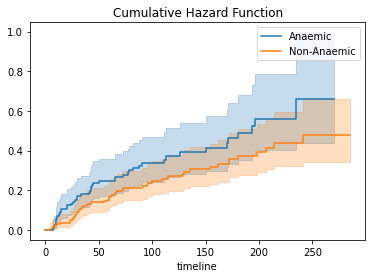

In [48]:
naf_a.plot_cumulative_hazard()
naf_na.plot_cumulative_hazard()
plt.title('Cumulative Hazard Function');

<AxesSubplot:xlabel='timeline'>

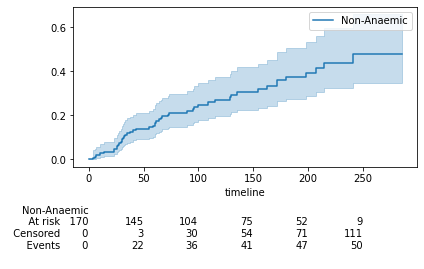

In [49]:
#naf_a.plot(at_risk_counts = True)
naf_na.plot(at_risk_counts = True)

### Fitting KM Curves

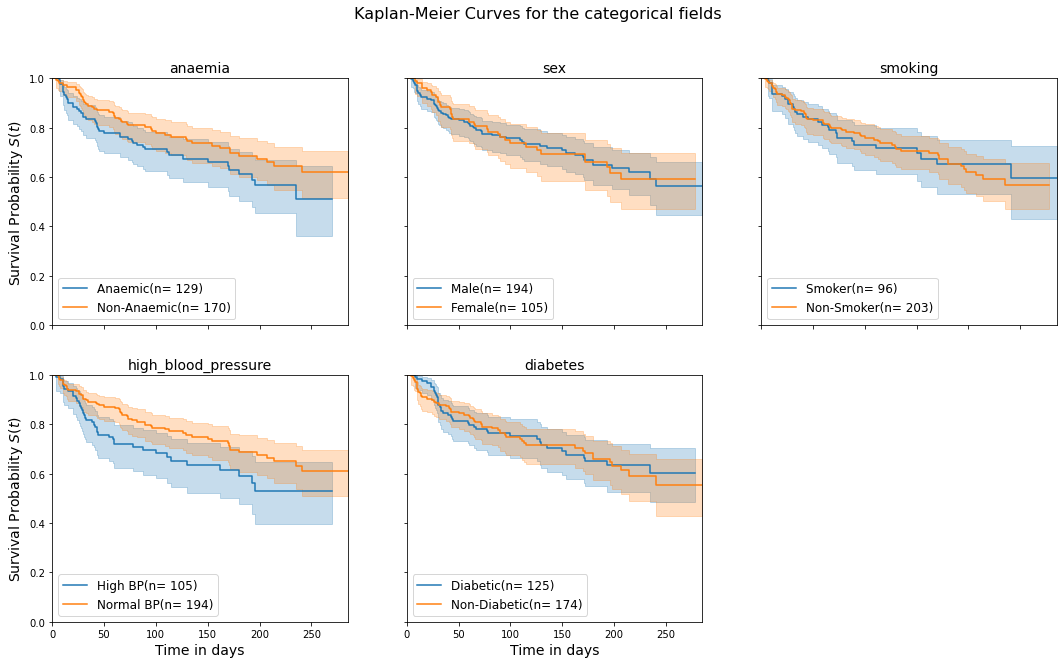

In [50]:
#Creating subplots: 2 rows and 3 columns to show the 5 categorical variables. The 6th one will be hidden.

fig, ax = plt.subplots(nrows=2, ncols=3, figsize=(18,10), sharex = True, sharey = True)
categorical_columns = ['anaemia', 'sex', 'smoking', 'high_blood_pressure', 'diabetes']
labels = ['Anaemic','Non-Anaemic', 'Male', 'Female', 'Smoker', 'Non-Smoker', 'High BP', 'Normal BP', 
          'Diabetic', 'Non-Diabetic']

for i,axx in zip(range(len(categorical_columns)), ax.flatten()):
    col_name = categorical_columns[i]
    y1 = survival_heart_df.query('{0}==1'.format(col_name))
    n1 = survival_heart_df.query('{0}==0'.format(col_name))
    
    kmf_y = KaplanMeierFitter()
    kmf_y.fit(y1['time'], y1['DEATH_EVENT'], label=labels[i*2] + '(n= %d)' % len(y1))
    kmf_y.plot(ax = axx)
    
    kmf_n = KaplanMeierFitter()
    kmf_n.fit(n1['time'], n1['DEATH_EVENT'], label=labels[i*2 + 1] + '(n= %d)' % len(n1))
    kmf_n.plot(ax = axx)
    
    axx.set_xlabel("Time in days", fontsize=14)
    axx.set_ylabel("Survival Probability $S(t)$", fontsize=14)
    axx.set_title(col_name, fontsize=14)
    axx.legend(loc='lower left', fontsize=12)
    axx.set_xlim(0, max(survival_heart_df['time']))
    axx.set_ylim(0, 1)

plt.suptitle('Kaplan-Meier Curves for the categorical fields', fontsize=16)
ax.flatten()[-1].set_visible(False) #The 6th plot will be empty. Hence we are hiding it.
plt.savefig('D:/UoL Study Material/Dissertation/Pictures/km_categorical.png', dpi=450)
plt.show()

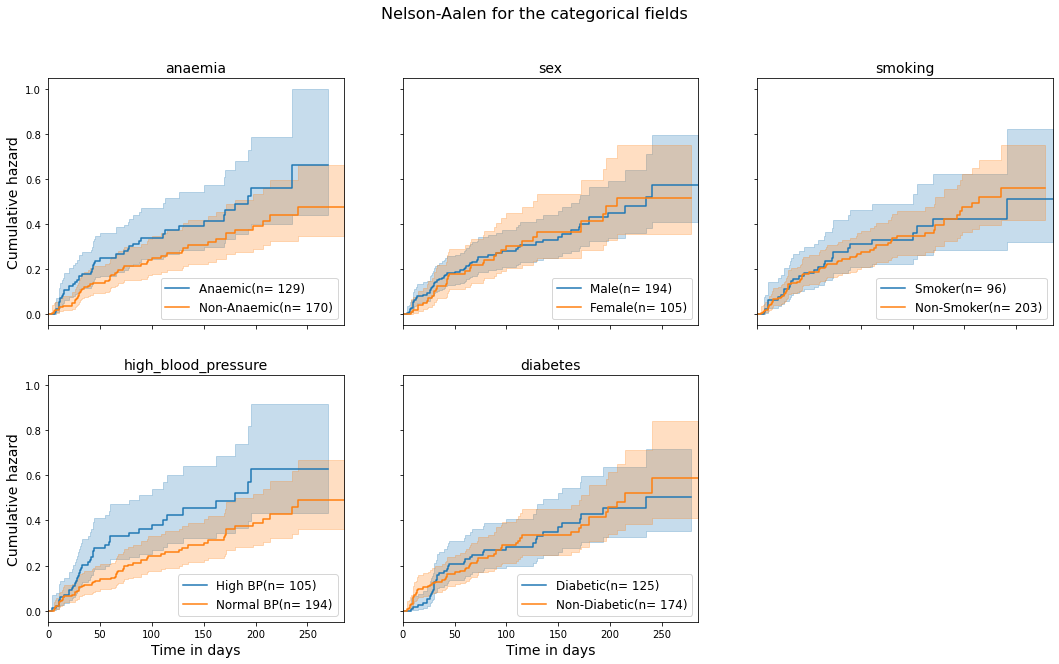

In [51]:
#Creating subplots: 2 rows and 3 columns to show the 5 categorical variables. The 6th one will be hidden.
fig, ax = plt.subplots(nrows=2, ncols=3, figsize=(18,10), sharex = True, sharey = True)
categorical_columns = ['anaemia', 'sex', 'smoking', 'high_blood_pressure', 'diabetes']
labels = ['Anaemic','Non-Anaemic', 'Male', 'Female', 'Smoker', 'Non-Smoker', 'High BP', 'Normal BP', 
          'Diabetic', 'Non-Diabetic']
na_cumulative_hazard_list = list()
for i,axx in zip(range(len(categorical_columns)), ax.flatten()):
    col_name = categorical_columns[i]
    y1 = survival_heart_df.query('{0}==1'.format(col_name))
    n1 = survival_heart_df.query('{0}==0'.format(col_name))
    
    naf_y = NelsonAalenFitter()
    naf_y.fit(y1['time'], event_observed=y1['DEATH_EVENT'], label=labels[i*2] + '(n= %d)' % len(y1))
    naf_y.plot(ax = axx)
    na_cumulative_hazard_list.append(naf_y.cumulative_hazard_)
    
    naf_n = NelsonAalenFitter()
    naf_n.fit(n1['time'], event_observed=n1['DEATH_EVENT'], label=labels[i*2 + 1] + '(n= %d)' % len(n1))
    naf_n.plot(ax = axx)
    na_cumulative_hazard_list.append(naf_n.cumulative_hazard_)
    
    axx.set_xlabel("Time in days", fontsize=14)
    axx.set_ylabel("Cumulative hazard", fontsize=14)
    axx.set_title(col_name, fontsize=14)
    axx.legend(loc='lower right', fontsize=12)
    axx.set_xlim(0, max(survival_heart_df['time']))
    #axx.set_ylim(0, 1)

plt.suptitle('Nelson-Aalen for the categorical fields', fontsize=16)
ax.flatten()[-1].set_visible(False) #The 6th plot will be empty. Hence we are hiding it.
plt.savefig('D:/UoL Study Material/Dissertation/Pictures/naf_categorical.png', dpi=450)
plt.show()

In [52]:
#The cumulative hazards for all the categories are shown here.

for i in range(0,len(na_cumulative_hazard_list)):
    (na_cumulative_hazard_list[0])
na_cumulative_hazard_list

[          Anaemic(n= 129)
 timeline                 
 0.0              0.000000
 7.0              0.007752
 8.0              0.023438
 10.0             0.055570
 11.0             0.072031
 ...                   ...
 245.0            0.661292
 246.0            0.661292
 250.0            0.661292
 256.0            0.661292
 270.0            0.661292
 
 [90 rows x 1 columns],
           Non-Anaemic(n= 170)
 timeline                     
 0.0                  0.000000
 4.0                  0.005882
 6.0                  0.011800
 7.0                  0.017752
 10.0                 0.029764
 ...                       ...
 270.0                0.477173
 271.0                0.477173
 278.0                0.477173
 280.0                0.477173
 285.0                0.477173
 
 [109 rows x 1 columns],
           Male(n= 194)
 timeline              
 0.0           0.000000
 4.0           0.005155
 6.0           0.010336
 7.0           0.020780
 8.0           0.026043
 ...                ...
 

### LogRank Test

In [53]:
#Statistical significance test: Log-Rank

results = logrank_test(y1['time'], n1['time'], event_observed_A=y1['DEATH_EVENT'], event_observed_B=n1['DEATH_EVENT'])
results.print_summary()

<lifelines.StatisticalResult: logrank_test>
               t_0 = -1
 null_distribution = chi squared
degrees_of_freedom = 1
         test_name = logrank_test

---
 test_statistic    p  -log2(p)
           0.04 0.84      0.25

In [54]:
#Log-Rank test was performed for all the categorical features.

categorical_columns = ['anaemia', 'sex', 'smoking', 'high_blood_pressure', 'diabetes']
log_rank_cat_df = pd.DataFrame(columns=["Feature", "Test_Statisic", "p-value", "-log2(p)"])

for i in range(len(categorical_columns)):
    col_name = categorical_columns[i]
    y1 = survival_heart_df.query('{0}==1'.format(col_name))
    n1 = survival_heart_df.query('{0}==0'.format(col_name))
    results = logrank_test(y1['time'], n1['time'], event_observed_A=y1['DEATH_EVENT'], event_observed_B=n1['DEATH_EVENT'])
    log_rank_cat_df.loc[i] = [col_name, round(results.test_statistic,2), round(results.p_value,2), round(-math.log2(results.p_value),2)]
    
log_rank_cat_df.sort_values(by='p-value')

Feature  Test_Statisic  p-value  -log2(p)
3  high_blood_pressure           4.41     0.04      4.80
0              anaemia           2.73     0.10      3.34
4             diabetes           0.04     0.84      0.25
1                  sex           0.00     0.95      0.07
2              smoking           0.00     0.96      0.05

From the results of the LogRank Test, we can conclude the following:

 - **high_blood_pressure** is a statistically significant feature, since the p-value associated with it is less than 0.05(0.04). 
 - **anaemia, diabetes, sex** and **smoking** all have p-values greater than 0.05. This leaves them all to be statistically insignificant in our analysis.

### Numerical columns: Creating bands

In [55]:
#Bands were created for the numerical fields.
#Band formation strategy: Split the features such that all bands of a feature have the same range.

survival_heart_df['Age_band'] = pd.cut(survival_heart_df['age'],3)
survival_heart_df['Creatinine_Phosphokinase_band'] = pd.cut(survival_heart_df['CP'],3)
survival_heart_df['Ejection_Fraction_band'] = pd.cut(survival_heart_df['EF'],3)
survival_heart_df['Platelets_band'] = pd.cut(survival_heart_df['platelets'],3)
survival_heart_df['Serum_Creatinine_band'] = pd.cut(survival_heart_df['serum_creatinine'],3)
survival_heart_df['Serum_Sodium_band'] = pd.cut(survival_heart_df['serum_sodium'],3)
survival_heart_df

age anaemia    CP diabetes  EF high_blood_pressure  platelets  \
0    75.0       0   582        0  20                   1  265000.00   
1    55.0       0  7861        0  38                   0  263358.03   
2    65.0       0   146        0  20                   0  162000.00   
3    50.0       1   111        0  20                   0  210000.00   
4    65.0       1   160        1  20                   0  327000.00   
..    ...     ...   ...      ...  ..                 ...        ...   
294  62.0       0    61        1  38                   1  155000.00   
295  55.0       0  1820        0  38                   0  270000.00   
296  45.0       0  2060        1  60                   0  742000.00   
297  45.0       0  2413        0  38                   0  140000.00   
298  50.0       0   196        0  45                   0  395000.00   

     serum_creatinine  serum_sodium sex smoking  time  DEATH_EVENT   died  \
0                 1.9           130   1       0     4            1   True   
1                 1.1           136   1       0     6            1   True   
2                 1.3           129   1       1     7            1   True   
3                 1.9           137   1       0     7            1   True   
4                 2.7           116   0       0     8            1   True   
..                ...           ...  ..     ...   ...          ...    ...   
294               1.1           143   1       1   270            0  False   
295               1.2           139   0       0   271            0  False   
296               0.8           138   0       0   278            0  False   
297               1.4           140   1       1   280            0  False   
298               1.6           136   1       1   285            0  False   

             Age_band Creatinine_Phosphokinase_band Ejection_Fraction_band  \
0    (58.333, 76.667]            (15.162, 2635.667]         (13.934, 36.0]   
1    (39.945, 58.333]            (5248.333, 7861.0]           (36.0, 58.0]   
2    (58.333, 76.667]            (15.162, 2635.667]         (13.934, 36.0]   
3    (39.945, 58.333]            (15.162, 2635.667]         (13.934, 36.0]   
4    (58.333, 76.667]            (15.162, 2635.667]         (13.934, 36.0]   
..                ...                           ...                    ...   
294  (58.333, 76.667]            (15.162, 2635.667]           (36.0, 58.0]   
295  (39.945, 58.333]            (15.162, 2635.667]           (36.0, 58.0]   
296  (39.945, 58.333]            (15.162, 2635.667]           (58.0, 80.0]   
297  (39.945, 58.333]            (15.162, 2635.667]           (36.0, 58.0]   
298  (39.945, 58.333]            (15.162, 2635.667]           (36.0, 58.0]   

               Platelets_band Serum_Creatinine_band   Serum_Sodium_band  
0       (24275.1, 300066.667]        (0.491, 3.467]  (124.667, 136.333]  
1       (24275.1, 300066.667]        (0.491, 3.467]  (124.667, 136.333]  
2       (24275.1, 300066.667]        (0.491, 3.467]  (124.667, 136.333]  
3       (24275.1, 300066.667]        (0.491, 3.467]    (136.333, 148.0]  
4    (300066.667, 575033.333]        (0.491, 3.467]  (112.965, 124.667]  
..                        ...                   ...                 ...  
294     (24275.1, 300066.667]        (0.491, 3.467]    (136.333, 148.0]  
295     (24275.1, 300066.667]        (0.491, 3.467]    (136.333, 148.0]  
296    (575033.333, 850000.0]        (0.491, 3.467]    (136.333, 148.0]  
297     (24275.1, 300066.667]        (0.491, 3.467]    (136.333, 148.0]  
298  (300066.667, 575033.333]        (0.491, 3.467]  (124.667, 136.333]  

[299 rows x 20 columns]

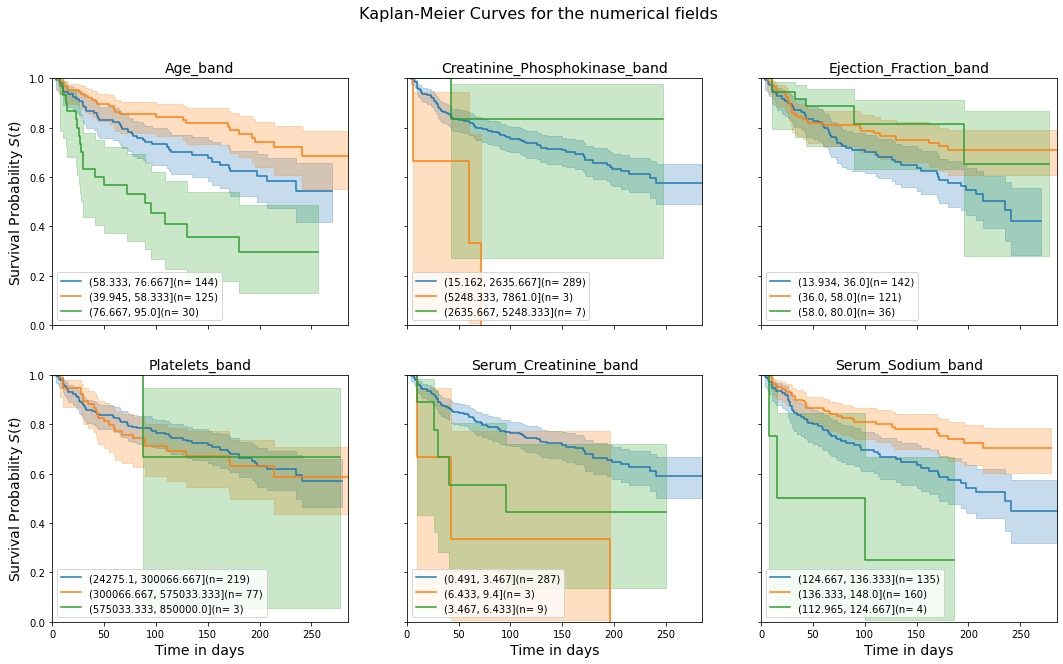

In [56]:
#Creating subplots: 2 rows and 3 columns to show the 6 numerical columns.
fig, ax = plt.subplots(nrows=2, ncols=3, figsize=(18,10), sharex = True, sharey = True)
numerical_columns = ['Age_band', 'Creatinine_Phosphokinase_band', 'Ejection_Fraction_band', 'Platelets_band', 
                     'Serum_Creatinine_band', 'Serum_Sodium_band']

for i,axx in zip(range(len(numerical_columns)), ax.flatten()):
    col_name = numerical_columns[i]  
    for unique_band in survival_heart_df[col_name].unique():
        band = survival_heart_df[col_name] == unique_band
        kmf_numerical = KaplanMeierFitter()
        kmf_numerical.fit(survival_heart_df[band]['time'], survival_heart_df[band]['DEATH_EVENT'], 
                          label=str(unique_band) + '(n= %d)' % len(survival_heart_df[band]))
        kmf_numerical.plot(ax = axx)
    
        axx.set_xlabel("Time in days", fontsize=14)
        axx.set_ylabel("Survival Probability $S(t)$", fontsize=14)
        axx.set_title(col_name, fontsize=14)
        axx.legend(loc='lower left', fontsize=10)
        axx.set_xlim(0, max(survival_heart_df['time']))
        axx.set_ylim(0, 1)

plt.suptitle('Kaplan-Meier Curves for the numerical fields', fontsize=16)
plt.savefig('D:/UoL Study Material/Dissertation/Pictures/km_num_1.png', dpi=450)
plt.show()

In [57]:
#Splitting the value based on quantiles - This will ensure an equal spread of records in all the three divisions.

survival_heart_df['AGE'] = pd.qcut(survival_heart_df['age'], [0,0.34, 0.66, 1])
survival_heart_df['CREATININE PHOSPHOKINASE'] = pd.qcut(survival_heart_df['CP'],3)
survival_heart_df['EJECTION FRACTION'] = pd.qcut(survival_heart_df['EF'],3)
survival_heart_df['PLATELETS'] = pd.qcut(survival_heart_df['platelets'],3)
survival_heart_df['SERUM CREATININE'] = pd.qcut(survival_heart_df['serum_creatinine'],3)
survival_heart_df['SERUM SODIUM'] = pd.qcut(survival_heart_df['serum_sodium'],3)
survival_heart_df

age anaemia    CP diabetes  EF high_blood_pressure  platelets  \
0    75.0       0   582        0  20                   1  265000.00   
1    55.0       0  7861        0  38                   0  263358.03   
2    65.0       0   146        0  20                   0  162000.00   
3    50.0       1   111        0  20                   0  210000.00   
4    65.0       1   160        1  20                   0  327000.00   
..    ...     ...   ...      ...  ..                 ...        ...   
294  62.0       0    61        1  38                   1  155000.00   
295  55.0       0  1820        0  38                   0  270000.00   
296  45.0       0  2060        1  60                   0  742000.00   
297  45.0       0  2413        0  38                   0  140000.00   
298  50.0       0   196        0  45                   0  395000.00   

     serum_creatinine  serum_sodium sex  ... Ejection_Fraction_band  \
0                 1.9           130   1  ...         (13.934, 36.0]   
1                 1.1           136   1  ...           (36.0, 58.0]   
2                 1.3           129   1  ...         (13.934, 36.0]   
3                 1.9           137   1  ...         (13.934, 36.0]   
4                 2.7           116   0  ...         (13.934, 36.0]   
..                ...           ...  ..  ...                    ...   
294               1.1           143   1  ...           (36.0, 58.0]   
295               1.2           139   0  ...           (36.0, 58.0]   
296               0.8           138   0  ...           (58.0, 80.0]   
297               1.4           140   1  ...           (36.0, 58.0]   
298               1.6           136   1  ...           (36.0, 58.0]   

               Platelets_band  Serum_Creatinine_band   Serum_Sodium_band  \
0       (24275.1, 300066.667]         (0.491, 3.467]  (124.667, 136.333]   
1       (24275.1, 300066.667]         (0.491, 3.467]  (124.667, 136.333]   
2       (24275.1, 300066.667]         (0.491, 3.467]  (124.667, 136.333]   
3       (24275.1, 300066.667]         (0.491, 3.467]    (136.333, 148.0]   
4    (300066.667, 575033.333]         (0.491, 3.467]  (112.965, 124.667]   
..                        ...                    ...                 ...   
294     (24275.1, 300066.667]         (0.491, 3.467]    (136.333, 148.0]   
295     (24275.1, 300066.667]         (0.491, 3.467]    (136.333, 148.0]   
296    (575033.333, 850000.0]         (0.491, 3.467]    (136.333, 148.0]   
297     (24275.1, 300066.667]         (0.491, 3.467]    (136.333, 148.0]   
298  (300066.667, 575033.333]         (0.491, 3.467]  (124.667, 136.333]   

                AGE CREATININE PHOSPHOKINASE EJECTION FRACTION  \
0      (65.0, 95.0]         (145.333, 582.0]    (13.999, 35.0]   
1    (39.999, 55.0]          (582.0, 7861.0]      (35.0, 40.0]   
2      (55.0, 65.0]         (145.333, 582.0]    (13.999, 35.0]   
3    (39.999, 55.0]        (22.999, 145.333]    (13.999, 35.0]   
4      (55.0, 65.0]         (145.333, 582.0]    (13.999, 35.0]   
..              ...                      ...               ...   
294    (55.0, 65.0]        (22.999, 145.333]      (35.0, 40.0]   
295  (39.999, 55.0]          (582.0, 7861.0]      (35.0, 40.0]   
296  (39.999, 55.0]          (582.0, 7861.0]      (40.0, 80.0]   
297  (39.999, 55.0]          (582.0, 7861.0]      (35.0, 40.0]   
298  (39.999, 55.0]         (145.333, 582.0]      (40.0, 80.0]   

                  PLATELETS SERUM CREATININE      SERUM SODIUM  
0    (226000.0, 278333.333]       (1.3, 9.4]  (112.999, 136.0]  
1    (226000.0, 278333.333]       (1.0, 1.3]  (112.999, 136.0]  
2     (25099.999, 226000.0]       (1.0, 1.3]  (112.999, 136.0]  
3     (25099.999, 226000.0]       (1.3, 9.4]    (136.0, 138.0]  
4    (278333.333, 850000.0]       (1.3, 9.4]  (112.999, 136.0]  
..                      ...              ...               ...  
294   (25099.999, 226000.0]       (1.0, 1.3]    (138.0, 148.0]  
295  (226000.0, 278333.333]       (1.0, 1.3]    (138.0, 148.0]  
296  (278

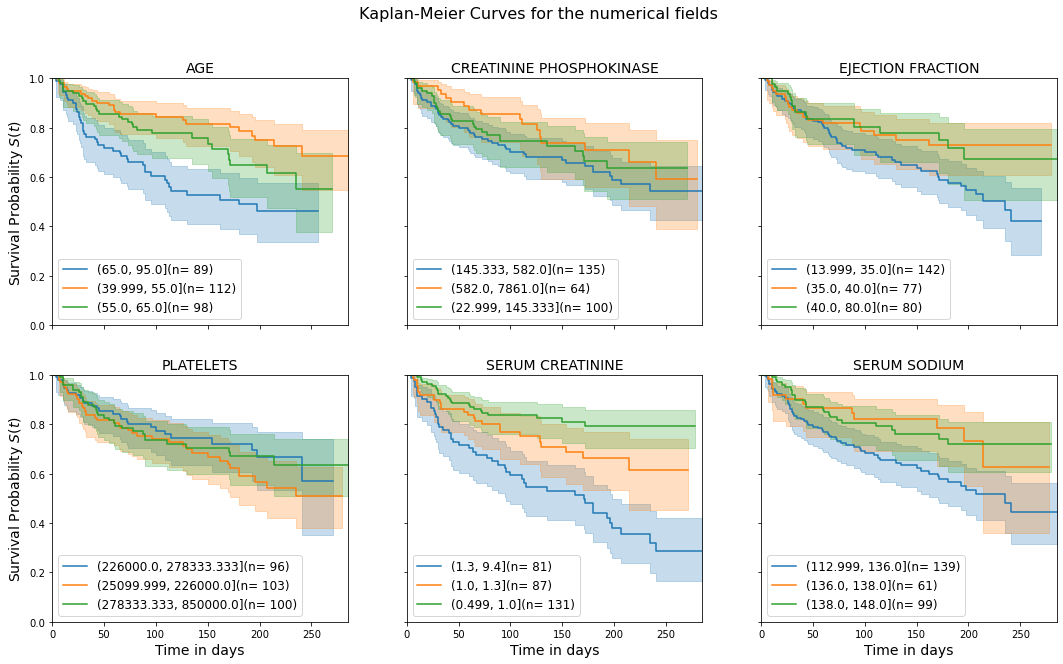

In [58]:
#Creating subplots: 2 rows and 3 columns to show the 6 numerical columns. 

fig, ax = plt.subplots(nrows=2, ncols=3, figsize=(18,10), sharex = True, sharey = True)
numerical_columns = ['AGE', 'CREATININE PHOSPHOKINASE', 'EJECTION FRACTION', 'PLATELETS', 'SERUM CREATININE', 'SERUM SODIUM']
surv_func_list = list()
for i,axx in zip(range(len(numerical_columns)), ax.flatten()):
    col_name = numerical_columns[i]  
    for unique_band in survival_heart_df[col_name].unique():
        band = survival_heart_df[col_name] == unique_band
        kmf_numerical = KaplanMeierFitter()
        kmf_numerical.fit(survival_heart_df[band]['time'], survival_heart_df[band]['DEATH_EVENT'], 
                          label=str(unique_band) + '(n= %d)' % len(survival_heart_df[band]))
        surv_func_list.append(kmf_numerical.survival_function_)
        kmf_numerical.plot(ax = axx)
    
        axx.set_xlabel("Time in days", fontsize=14)
        axx.set_ylabel("Survival Probability $S(t)$", fontsize=14)
        axx.set_title(col_name, fontsize=14)
        axx.legend(loc='lower left', fontsize=12)
        axx.set_xlim(0, max(survival_heart_df['time']))
        axx.set_ylim(0, 1)

plt.suptitle('Kaplan-Meier Curves for the numerical fields', fontsize=16)
plt.savefig('D:/UoL Study Material/Dissertation/Pictures/km_num_2.png', dpi=450)
plt.show()

In [59]:
surv_func_list

[          (65.0, 95.0](n= 89)
 timeline                     
 0.0                  1.000000
 4.0                  0.988764
 8.0                  0.977528
 10.0                 0.943820
 13.0                 0.932584
 ...                       ...
 245.0                0.460824
 246.0                0.460824
 247.0                0.460824
 250.0                0.460824
 256.0                0.460824
 
 [73 rows x 1 columns],
           (39.999, 55.0](n= 112)
 timeline                        
 0.0                     1.000000
 6.0                     0.991071
 7.0                     0.982143
 11.0                    0.964286
 12.0                    0.964286
 ...                          ...
 258.0                   0.686650
 271.0                   0.686650
 278.0                   0.686650
 280.0                   0.686650
 285.0                   0.686650
 
 [80 rows x 1 columns],
           (55.0, 65.0](n= 98)
 timeline                     
 0.0                  1.000000
 7.0      

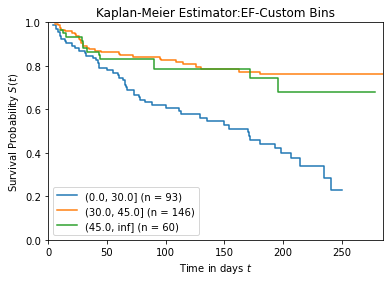

In [60]:
#Creating a custom band here to replicate the KM curve produced by the original authors of this dataset. 

ef_bins = [0, 30, 45, np.inf]
survival_heart_df['EF_CustomBins'] = pd.cut(survival_heart_df['EF'], ef_bins)
for v in survival_heart_df["EF_CustomBins"].unique():
    mask = survival_heart_df["EF_CustomBins"] == v
    time_cell, survival_prob_cell = kaplan_meier_estimator(survival_heart_df["died"][mask],
                                                           survival_heart_df["time"][mask])
    plt.step(time_cell, survival_prob_cell, where="post",
             label="%s (n = %d)" % (v, mask.sum()))

plt.ylabel("Survival Probability $S(t)$")
plt.xlabel("Time in days $t$")
plt.legend(loc="best")
plt.title("Kaplan-Meier Estimator:EF-Custom Bins")
plt.axis((0, max(survival_heart_df['time']), 0, 1.0));
plt.savefig('D:/UoL Study Material/Dissertation/Pictures/km_ef_custombins.png', dpi=450)
plt.show()

### Cox Proportional Hazards Model

<lifelines.CoxPHFitter: fitted with 299 total observations, 203 right-censored observations>
             duration col = 'time'
                event col = 'DEATH_EVENT'
      baseline estimation = breslow
   number of observations = 299
number of events observed = 96
   partial log-likelihood = -468.23
         time fit was run = 2022-09-02 15:09:36 UTC

---
                      coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                   
age                   0.05       1.05       0.01             0.03             0.06                 1.03                 1.07
anaemia               0.46       1.58       0.22             0.04             0.89                 1.04                 2.42
CP                    0.00       1.00       0.00             0.00             0.00                 1.00                 1.00
diabetes              0.14       1.15       0.22            -0.30             0.58                 0.74                 1.78
EF                   -0.05       0.95       0.01            -0.07            -0.03                 0.93                 0.97
high_blood_pressure   0.48       1.61       0.22             0.05             0.90                 1.05                 2.46
platelets            -0.00       1.00       0.00            -0.00             0.00                 1.00                 1.00
serum_creatinine      0.32       1.38       0.07             0.18             0.46                 1.20                 1.58
serum_sodium         -0.04       0.96       0.02            -0.09             0.00                 0.91                 1.00
sex                  -0.24       0.79       0.25            -0.73             0.26                 0.48                 1.29
smoking               0.13       1.14       0.25            -0.36             0.62                 0.70                 1.86

                      cmp to     z      p   -log2(p)
covariate                                           
age                     0.00  4.98 <0.005      20.56
anaemia                 0.00  2.12   0.03       4.89
CP                      0.00  2.23   0.03       5.26
diabetes                0.00  0.63   0.53       0.91
EF                      0.00 -4.67 <0.005      18.35
high_blood_pressure     0.00  2.20   0.03       5.17
platelets               0.00 -0.41   0.68       0.56
serum_creatinine        0.00  4.58 <0.005      17.68
serum_sodium            0.00 -1.90   0.06       4.12
sex                     0.00 -0.94   0.35       1.53
smoking                 0.00  0.51   0.61       0.72
---
Concordance = 0.74
Partial AIC = 958.46
log-likelihood ratio test = 81.95 on 11 df
-log2(p) of ll-ratio test = 40.56

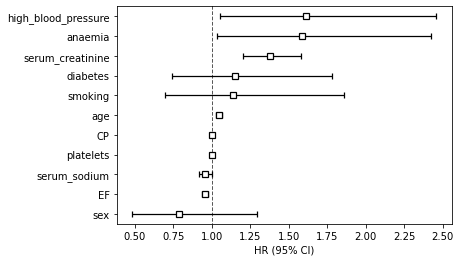

In [61]:
cph = CoxPHFitter()

sur_df = survival_heart_df[['age','anaemia','CP','diabetes','EF','high_blood_pressure','platelets','serum_creatinine',
                            'serum_sodium','sex','smoking','time','DEATH_EVENT']]
cph.fit(sur_df, "time", event_col="DEATH_EVENT")
cph.print_summary()
cph.plot(hazard_ratios = True);
plt.savefig('D:/UoL Study Material/Dissertation/Pictures/cox_ph.png', dpi=450, bbox_inches='tight')

The ``p_value_threshold`` is set at 0.05. Even under the null hypothesis of no violations, some
covariates will be below the threshold by chance. This is compounded when there are many covariates.
Similarly, when there are lots of observations, even minor deviances from the proportional hazard
assumption will be flagged.

With that in mind, it's best to use a combination of statistical tests and visual tests to determine
the most serious violations. Produce visual plots using ``check_assumptions(..., show_plots=True)``
and looking for non-constant lines. See link [A] below for a full example.



<lifelines.StatisticalResult: proportional_hazard_test>
 null_distribution = chi squared
degrees_of_freedom = 1
             model = <lifelines.CoxPHFitter: fitted with 299 total observations, 203 right-censored observations>
         test_name = proportional_hazard_test

---
                          test_statistic    p  -log2(p)
CP                  km              1.13 0.29      1.79
                    rank            1.11 0.29      1.77
EF                  km              5.85 0.02      6.00
                    rank            6.21 0.01      6.30
age                 km              0.11 0.74      0.43
                    rank            0.03 0.86      0.21
anaemia             km              0.00 1.00      0.00
                    rank            0.01 0.93      0.11
diabetes            km              0.04 0.84      0.25
                    rank            0.00 0.99      0.02
high_blood_pressure km              0.11 0.74      0.44
                    rank            0.11 0.74      0.44
platelets           km              0.04 0.85      0.24
                    rank            0.11 0.74      0.44
serum_creatinine    km              3.22 0.07      3.78
                    rank            3.48 0.06      4.00
serum_sodium        km              1.10 0.29      1.76
                    rank            1.73 0.19      2.41
sex                 km              0.09 0.76      0.39
                    rank            0.26 0.61      0.71
smoking             km              0.58 0.45      1.16
                    rank            0.33 0.57      0.82



1. Variable 'EF' failed the non-proportional test: p-value is 0.0127.

   Advice 1: the functional form of the variable 'EF' might be incorrect. That is, there may be non-
linear terms missing. The proportional hazard test used is very sensitive to incorrect functional
forms. See documentation in link [D] below on how to specify a functional form.

   Advice 2: try binning the variable 'EF' using pd.cut, and then specify it in `strata=['EF', ...]`
in the call in `.fit`. See documentation in link [B] below.

   Advice 3: try adding an interaction term with your time variable. See documentation in link [C]
below.


   Bootstrapping lowess lines. May take a moment...


---
[A]  https://lifelines.readthedocs.io/en/latest/jupyter_notebooks/Proportional%20hazard%20assumption.html
[B]  https://lifelines.readthedocs.io/en/latest/jupyter_notebooks/Proportional%20hazard%20assumption.html#Bin-variable-and-stratify-on-it
[C]  https://lifelines.readthedocs.io/en/latest/jupyter_notebooks/Proportio

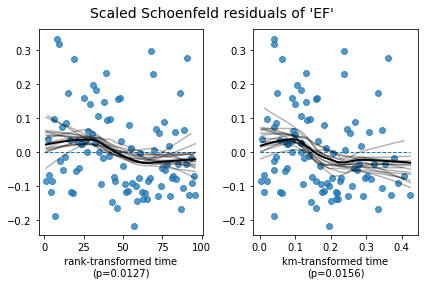

In [62]:
#Cox model follows certain assumptions. They are checked here.
#Any violation of the assumptions is highlighted by plotting the Scaled Schoenfeld residuals against time. 
#A non-zero slope is an indicator of a violation of the assumptions of Cox model.

cph_assumptions = cph.check_assumptions(sur_df, p_value_threshold=0.05, show_plots=True)
plt.savefig('D:/UoL Study Material/Dissertation/Pictures/prop_hazard.png', dpi=450)

In [63]:
scaled_schoenfeld_residuals = cph.compute_residuals(training_dataframe=sur_df, kind='scaled_schoenfeld')
scaled_schoenfeld_residuals

covariate       age   anaemia        CP  diabetes        EF  \
0          0.029181 -2.534108 -0.000196 -1.920012 -0.086081   
1         -0.159522  0.304565  0.006313 -2.311258  0.036891   
2         -0.023412 -1.663582 -0.000752 -2.102169 -0.069506   
3         -0.176964  1.622392 -0.000372 -2.703846 -0.118529   
4          0.006485  3.285129  0.000270  1.035642 -0.085165   
..              ...       ...       ...       ...       ...   
220        0.059532 -1.530999 -0.000117 -1.266956 -0.126285   
230       -0.003280 -0.592851 -0.000138 -2.563663 -0.019419   
246       -0.090098 -1.144823  0.001090 -2.682072 -0.091645   
262        0.044870  2.812529  0.000064  1.646497 -0.070495   
266       -0.064797 -0.477913  0.000382 -2.337164 -0.128022   

covariate  high_blood_pressure  platelets  serum_creatinine  serum_sodium  \
0                     2.632773   0.000002         -0.573398     -0.194486   
1                    -0.961301   0.000003         -0.333385     -0.071121   
2                    -1.667322  -0.000012         -0.828950     -0.226883   
3                    -2.396876  -0.000001         -0.322690      0.138632   
4                    -2.537070   0.000008         -0.463775     -0.894777   
..                         ...        ...               ...           ...   
220                  -0.616389   0.000005          0.121736      0.006764   
230                  -0.548999  -0.000022         -0.496447     -0.408447   
246                  -0.564820   0.000012          0.077684      0.088915   
262                  -0.161185  -0.000002         -0.171071     -0.332841   
266                  -0.172603   0.000005          0.191119     -0.103519   

covariate       sex   smoking  
0          2.493397 -3.525558  
1          1.597442 -4.342716  
2         -0.837723  2.731001  
3          2.265799 -3.293539  
4         -4.040465 -0.189341  
..              ...       ...  
220        2.378666 -2.899884  
230       -3.836693  0.304089  
246        2.815149 -3.721639  
262        1.891063 -2.384099  
266        0.120194  1.864681  

[96 rows x 11 columns]

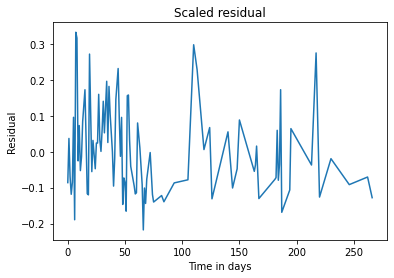

In [64]:
plt.plot(scaled_schoenfeld_residuals.index, scaled_schoenfeld_residuals['EF'])
plt.xlabel('Time in days')
plt.ylabel('Residual')
plt.title('Scaled residual')
plt.show()

### Model Comparison: Before applying SMOTE

In [69]:
seed = 42

models = [LogisticRegression(random_state= seed),
         RandomForestClassifier(random_state= seed),
         GradientBoostingClassifier(random_state= seed),
         XGBClassifier(random_state= seed),
         KNeighborsClassifier(),
         DecisionTreeClassifier(random_state= seed),
         SVC(kernel='sigmoid', random_state= seed)]

lr_params = {"solver" : ['newton-cg', 'lbfgs', 'liblinear'],
             "penalty" : ['l2'],
             "C" : [100,10,1,0.1,0.01]}
rf_params = {"n_estimators" : [2,3,4,5,10], 
            "max_depth":[2,4],
            "min_samples_split": [35,50,65,80],
            "criterion": ['gini', 'entropy'],
            "max_features": [1,2]}
gb_params = {"n_estimators" : [2,4,5, 10, 12, 14, 15, 18, 20],
            "learning_rate" : [0.05],
            "max_depth" : [2, 4, 6, 8],
            "min_samples_split": [35,50,65,80]}
xgb_params = {"n_estimators":[2,3,4,5,10],
              "max_depth" : [2, 4],
              "eta" : [0.25, 0.75],
              "eval_metric":["error", "logloss"]}
knn_params = {"leaf_size": [2,3,4,5,10,15,20],
             "n_neighbors": [2,4,6,8,10],
             "p":[1,2]}
dtc_params = {"max_depth":[2,4],
              "min_samples_split": [35,50,65,80]},
svc_params = {'C': [0.1, 1, 10, 100, 1000],
              'gamma': [1, 0.1, 0.01, 0.001, 0.0001]}

In [70]:
hyper_params = [lr_params,rf_params,gb_params,xgb_params,knn_params,dtc_params,svc_params]

In [71]:
#Excluding Time from our analysis
ct = ColumnTransformer(transformers=[('scaler',StandardScaler(), ['age', 'CP', 'EF', 'platelets', 'serum_creatinine', 'serum_sodium']),
                                    ],remainder='passthrough')

In [72]:
X = heart_df.drop(['time','DEATH_EVENT'], axis = 1)
y = heart_df['DEATH_EVENT']
X

age anaemia    CP diabetes  EF high_blood_pressure  platelets  \
0    75.0       0   582        0  20                   1  265000.00   
1    55.0       0  7861        0  38                   0  263358.03   
2    65.0       0   146        0  20                   0  162000.00   
3    50.0       1   111        0  20                   0  210000.00   
4    65.0       1   160        1  20                   0  327000.00   
..    ...     ...   ...      ...  ..                 ...        ...   
294  62.0       0    61        1  38                   1  155000.00   
295  55.0       0  1820        0  38                   0  270000.00   
296  45.0       0  2060        1  60                   0  742000.00   
297  45.0       0  2413        0  38                   0  140000.00   
298  50.0       0   196        0  45                   0  395000.00   

     serum_creatinine  serum_sodium sex smoking  
0                 1.9           130   1       0  
1                 1.1           136   1       0  
2                 1.3           129   1       1  
3                 1.9           137   1       0  
4                 2.7           116   0       0  
..                ...           ...  ..     ...  
294               1.1           143   1       1  
295               1.2           139   0       0  
296               0.8           138   0       0  
297               1.4           140   1       1  
298               1.6           136   1       1  

[299 rows x 11 columns]

In [73]:
scores_df = pd.DataFrame(columns=['Model Name','Mean Validation F1-Score', 'Mean Validation Recall Score', 
                                  'Mean Validation ROC-AUC Score', 'Mean Validation Accuracy',
                                  'Train F1-Score', 'Train Recall Score', 'Train ROC-AUC Score', 'Train Accuracy',
                                 'Test F1-Score', 'Test Recall Score', 'Test ROC-AUC Score', 'Test Accuracy'])
best_params = list()
start = currentTime()
ctr = 0
for mod in models:
	f1_scores = list()
	recall_scores = list()
	roc_auc_scores = list()
	accuracy_scores = list()
	f1_scores_train = list()
	recall_scores_train = list()
	roc_auc_scores_train = list()
	accuracy_scores_train = list()
	for i in range(10):
		X_train, X_test, y_train, y_test = train_test_split(X, y, stratify = y, test_size=0.3, random_state=i**2)
		X_train = ct.fit_transform(X_train)
		X_test = ct.transform(X_test)
		cv_inner = RepeatedStratifiedKFold(n_splits=10, n_repeats=2, random_state=i**2)
		# define search
		print(mod.__class__.__name__)
		search = GridSearchCV(mod, hyper_params[ctr], scoring=['f1','recall','roc_auc','accuracy'], 
							cv=cv_inner, refit='recall', n_jobs=-1)
		# execute search
		result = search.fit(X_train, y_train)
		# get the best performing model fit on the whole training set
		best_model = result.best_estimator_
		# evaluate model on the hold out dataset
		yhat = best_model.predict(X_test)
		#print(y_test,"\n", yhat)
		# evaluate the model
		f1 = f1_score(y_test, yhat)
		recall = recall_score(y_test, yhat)
		roc_auc = roc_auc_score(y_test, yhat)
		accuracy = accuracy_score(y_test, yhat)
		print(confusion_matrix(y_test, yhat))
		# store the result
		f1_scores.append(f1)
		recall_scores.append(recall)
		roc_auc_scores.append(roc_auc)
		accuracy_scores.append(accuracy)
		best_params.append(best_model)
        
		ypred_train = best_model.predict(X_train)
		f1_scores_train.append(f1_score(y_train, ypred_train))
		recall_scores_train.append(recall_score(y_train, ypred_train))
		roc_auc_scores_train.append(roc_auc_score(y_train, ypred_train))
		accuracy_scores_train.append(accuracy_score(y_train, ypred_train))
        
		#print(result)
		print('>Recall value=%.3f, Best params=%s' % (recall, result.best_params_))
		print()
	scores_df.loc[ctr] = [mod.__class__.__name__, result.cv_results_['mean_test_f1'].mean(), result.cv_results_['mean_test_recall'].mean(), 
								result.cv_results_['mean_test_roc_auc'].mean(), result.cv_results_['mean_test_accuracy'].mean(),
					mean(f1_scores_train), mean(recall_scores_train), mean(roc_auc_scores_train), mean(accuracy_scores_train),
					mean(f1_scores), mean(recall_scores), mean(roc_auc_scores), mean(accuracy_scores)]
	ctr = ctr+1
# summarize the estimated performance of the model
#print('F1 Score: %.3f (%.3f)' % (mean(outer_results), std(outer_results)))
print("The time taken:", round(currentTime() - start,2)," seconds")

LogisticRegression
[[54  7]
 [15 14]]
>Recall value=0.483, Best params={'C': 100, 'penalty': 'l2', 'solver': 'newton-cg'}

LogisticRegression
[[55  6]
 [22  7]]
>Recall value=0.241, Best params={'C': 100, 'penalty': 'l2', 'solver': 'newton-cg'}

LogisticRegression
[[49 12]
 [12 17]]
>Recall value=0.586, Best params={'C': 1, 'penalty': 'l2', 'solver': 'liblinear'}

LogisticRegression
[[49 12]
 [15 14]]
>Recall value=0.483, Best params={'C': 1, 'penalty': 'l2', 'solver': 'liblinear'}

LogisticRegression
[[49 12]
 [14 15]]
>Recall value=0.517, Best params={'C': 100, 'penalty': 'l2', 'solver': 'newton-cg'}

LogisticRegression
[[49 12]
 [15 14]]
>Recall value=0.483, Best params={'C': 100, 'penalty': 'l2', 'solver': 'newton-cg'}

LogisticRegression
[[51 10]
 [17 12]]
>Recall value=0.414, Best params={'C': 10, 'penalty': 'l2', 'solver': 'newton-cg'}

LogisticRegression
[[52  9]
 [14 15]]
>Recall value=0.517, Best params={'C': 100, 'penalty': 'l2', 'solver': 'newton-cg'}

LogisticRegression
[[

[[48 13]
 [ 5 24]]
>Recall value=0.828, Best params={'max_depth': 4, 'min_samples_split': 50}

SVC
[[37 24]
 [14 15]]
>Recall value=0.517, Best params={'C': 100, 'gamma': 0.1}

SVC
[[51 10]
 [19 10]]
>Recall value=0.345, Best params={'C': 100, 'gamma': 0.01}

SVC
[[44 17]
 [12 17]]
>Recall value=0.586, Best params={'C': 1000, 'gamma': 0.01}

SVC
[[48 13]
 [14 15]]
>Recall value=0.517, Best params={'C': 1000, 'gamma': 0.1}

SVC
[[46 15]
 [12 17]]
>Recall value=0.586, Best params={'C': 10, 'gamma': 0.1}

SVC
[[40 21]
 [16 13]]
>Recall value=0.448, Best params={'C': 100, 'gamma': 1}

SVC
[[52  9]
 [18 11]]
>Recall value=0.379, Best params={'C': 100, 'gamma': 0.1}

SVC
[[48 13]
 [15 14]]
>Recall value=0.483, Best params={'C': 10, 'gamma': 0.1}

SVC
[[52  9]
 [15 14]]
>Recall value=0.483, Best params={'C': 1000, 'gamma': 0.1}

SVC
[[54  7]
 [17 12]]
>Recall value=0.414, Best params={'C': 100, 'gamma': 0.1}

The time taken: 91.18  seconds


In [74]:
scores_df.sort_values(by='Test Recall Score', ascending=False)

Model Name  Mean Validation F1-Score  \
5      DecisionTreeClassifier                  0.433148   
3               XGBClassifier                  0.426586   
0          LogisticRegression                  0.373184   
6                         SVC                  0.220613   
2  GradientBoostingClassifier                  0.133205   
1      RandomForestClassifier                  0.142634   
4        KNeighborsClassifier                  0.178860   

   Mean Validation Recall Score  Mean Validation ROC-AUC Score  \
5                      0.466667                       0.688223   
3                      0.380655                       0.728463   
0                      0.303413                       0.719484   
6                      0.197048                       0.684107   
2                      0.101554                       0.735467   
1                      0.101793                       0.646734   
4                      0.120357                       0.680306   

   Mean Validation Accuracy  Train F1-Score  Train Recall Score  \
5                  0.681964        0.693479            0.726866   
3                  0.706363        0.800804            0.755224   
0                  0.709579        0.581693            0.497015   
6                  0.673481        0.505016            0.488060   
2                  0.680251        0.740668            0.656716   
1                  0.689597        0.464630            0.349254   
4                  0.679143        0.477021            0.343284   

   Train ROC-AUC Score  Train Accuracy  Test F1-Score  Test Recall Score  \
5             0.780334        0.799522       0.594440           0.631034   
3             0.847682        0.880861       0.552880           0.520690   
0             0.699564        0.772249       0.529060           0.475862   
6             0.638396        0.692344       0.487285           0.475862   
2             0.801950        0.854067       0.515488           0.458621   
1             0.645402        0.751675       0.391423           0.317241   
4             0.650515        0.760766       0.306951           0.213793   

   Test ROC-AUC Score  Test Accuracy  
5            0.708960       0.736667  
3            0.676738       0.732222  
0            0.664161       0.731111  
6            0.624816       0.677778  
2            0.657999       0.728889  
1            0.602883       0.704444  
4            0.565093       0.690000

In [75]:
best_params

[LogisticRegression(C=100, random_state=42, solver='newton-cg'),
 LogisticRegression(C=100, random_state=42, solver='newton-cg'),
 LogisticRegression(C=1, random_state=42, solver='liblinear'),
 LogisticRegression(C=1, random_state=42, solver='liblinear'),
 LogisticRegression(C=100, random_state=42, solver='newton-cg'),
 LogisticRegression(C=100, random_state=42, solver='newton-cg'),
 LogisticRegression(C=10, random_state=42, solver='newton-cg'),
 LogisticRegression(C=100, random_state=42, solver='newton-cg'),
 LogisticRegression(C=100, random_state=42, solver='newton-cg'),
 LogisticRegression(C=10, random_state=42, solver='liblinear'),
 RandomForestClassifier(max_depth=4, max_features=1, min_samples_split=35,
                        n_estimators=2, random_state=42),
 RandomForestClassifier(criterion='entropy', max_depth=4, max_features=1,
                        min_samples_split=35, n_estimators=4, random_state=42),
 RandomForestClassifier(max_depth=4, max_features=1, min_samples_spli

In [76]:
px.bar(scores_df.sort_values(by='Mean Validation Recall Score', ascending=False),x='Model Name', y='Mean Validation Recall Score', barmode='group',color='Mean Validation Recall Score')

### Model Comparison: After applying SMOTE

In [77]:
lr_params = {"solver" : ['newton-cg', 'lbfgs', 'liblinear'],
             "penalty" : ['l2'],
             "C" : [100,10,1,0.1,0.01]}
rf_params = {"n_estimators" : [2,3,4,5,10, 20, 50], 
                  "max_depth":[2,4],
                  "min_samples_split": [50,60,70,80]}
gb_params = {"n_estimators" : [2,3,4,5,10],
            "learning_rate" : [0.1,1,5,10],
            "max_depth" : [2, 4],
            "min_samples_split": [40,50,70,80],
            "max_features": [1,2]}
xgb_params = {"n_estimators":[2,3,4,5,10],
              "max_depth" : [2, 4],
              "eta" : [0.25, 0.75],
              "early_stopping_rounds" : [10,15,20],
             "eval_metric":["error", "logloss"]}
knn_params = {"leaf_size": [10,15,20],
             "n_neighbors": [2,4,6,8,10],
             "p":[1,2]}
dtc_params = {"max_depth":[2,4],
              "min_samples_split": [50,60,70,80]},
svc_params = {'C': [0.1, 1, 10, 100, 1000],
              'gamma': [1, 0.1, 0.01, 0.001, 0.0001]}

In [78]:
def create_smote_dataframe(X_train, y_train, rs):
    smote = SMOTE(random_state = rs)
    X_smote, y_smote = smote.fit_resample(X_train, y_train)
    
    smote_df = pd.DataFrame(X_smote, columns=ct.get_feature_names_out())
    smote_df.columns = smote_df.columns.str.replace("scaler__", "")
    smote_df.columns = smote_df.columns.str.replace('remainder__', '')
    smote_df['anaemia'] = round(smote_df.anaemia)
    smote_df['diabetes'] = round(smote_df.diabetes)
    smote_df['high_blood_pressure'] = round(smote_df.high_blood_pressure)
    smote_df['sex'] = round(smote_df.sex)
    smote_df['smoking'] = round(smote_df.smoking)
    return X_smote, y_smote, smote_df

smote_scores_df = pd.DataFrame(columns=['Model Name','Mean Validation F1-Score-SMOTE', 'Mean Validation Recall Score-SMOTE', 
                                  'Mean validation ROC-AUC Score-SMOTE', 'Mean Validation Accuracy-SMOTE',
                                    'Train F1-Score', 'Train Recall Score', 'Train ROC-AUC Score', 'Train Accuracy',
                                 'Test F1-Score', 'Test Recall Score', 'Test ROC-AUC Score', 'Test Accuracy'])
smote_df = pd.DataFrame()
smote_models = [LogisticRegression(random_state= seed),
         RandomForestClassifier(random_state= seed),
         GradientBoostingClassifier(random_state= seed),
         XGBClassifier(random_state= seed),
         KNeighborsClassifier(),
         DecisionTreeClassifier(random_state= seed),
         SVC(kernel='sigmoid', random_state= seed)]

hyper_params = [lr_params,rf_params,gb_params,xgb_params,knn_params,dtc_params,svc_params]


best_params_smote = list()
start = currentTime()
ctr = 0
for mod in smote_models:
	f1_scores = list()
	recall_scores = list()
	roc_auc_scores = list()
	accuracy_scores = list()
	f1_scores_train = list()
	recall_scores_train = list()
	roc_auc_scores_train = list()
	accuracy_scores_train = list()
	for i in range(10):
		X_train, X_test, y_train, y_test = train_test_split(X, y, stratify = y, test_size=0.3, random_state=i**2)
		X_train = ct.fit_transform(X_train)
		X_test = ct.transform(X_test)
		#print(i*150, X_train[0:2])
		X_smote, y_smote, smote_df = create_smote_dataframe(X_train, y_train, i**2)
		cv_inner = RepeatedStratifiedKFold(n_splits=10, n_repeats=2, random_state=i**2)
		# define search
		print(mod.__class__.__name__)
		search = GridSearchCV(mod, hyper_params[ctr], scoring=['f1','recall','roc_auc','accuracy'], 
							cv=cv_inner, refit='accuracy', n_jobs=-1)
		# execute search
		if(ctr==3):
			eval_set = [(X_smote, y_smote), (X_test, y_test)]
			result = search.fit(X_smote, y_smote, eval_set = eval_set, verbose=True)
		else:
			result = search.fit(X_smote, y_smote)
		# get the best performing model fit on the whole training set
		best_model = result.best_estimator_
		# evaluate model on the hold out dataset
		yhat = best_model.predict(X_test)
		#print(y_test,"\n", yhat)
		# evaluate the model
		f1 = f1_score(y_test, yhat)
		recall = recall_score(y_test, yhat)
		roc_auc = roc_auc_score(y_test, yhat)
		accuracy = accuracy_score(y_test, yhat)
		print(confusion_matrix(y_test, yhat))
		# store the result
		f1_scores.append(f1)
		recall_scores.append(recall)
		roc_auc_scores.append(roc_auc)
		accuracy_scores.append(accuracy)
		best_params_smote.append(best_model)
        
		ypred_train = best_model.predict(X_smote)
		f1_scores_train.append(f1_score(y_smote, ypred_train))
		recall_scores_train.append(recall_score(y_smote, ypred_train))
		roc_auc_scores_train.append(roc_auc_score(y_smote, ypred_train))
		accuracy_scores_train.append(accuracy_score(y_smote, ypred_train))
		#print(result)
		print('>Accuracy value=%.3f, Best params=%s' % (accuracy, result.best_params_))
		print()
	smote_scores_df.loc[ctr] = [mod.__class__.__name__, result.cv_results_['mean_test_f1'].mean(), result.cv_results_['mean_test_recall'].mean(), 
								result.cv_results_['mean_test_roc_auc'].mean(), result.cv_results_['mean_test_accuracy'].mean(),
					mean(f1_scores_train), mean(recall_scores_train), mean(roc_auc_scores_train), mean(accuracy_scores_train),
					mean(f1_scores), mean(recall_scores), mean(roc_auc_scores), mean(accuracy_scores)]
	ctr = ctr+1
# summarize the estimated performance of the model
#print('F1 Score: %.3f (%.3f)' % (mean(outer_results), std(outer_results)))
print("The time taken:", round(currentTime() - start,2)," seconds")

LogisticRegression
[[48 13]
 [11 18]]
>accuracy=0.733, est=0.778, cfg={'C': 0.01, 'penalty': 'l2', 'solver': 'newton-cg'}

LogisticRegression
[[47 14]
 [14 15]]
>accuracy=0.689, est=0.817, cfg={'C': 0.1, 'penalty': 'l2', 'solver': 'newton-cg'}

LogisticRegression
[[45 16]
 [ 7 22]]
>accuracy=0.744, est=0.776, cfg={'C': 0.1, 'penalty': 'l2', 'solver': 'newton-cg'}

LogisticRegression
[[41 20]
 [ 7 22]]
>accuracy=0.700, est=0.770, cfg={'C': 0.1, 'penalty': 'l2', 'solver': 'newton-cg'}

LogisticRegression
[[42 19]
 [ 7 22]]
>accuracy=0.711, est=0.721, cfg={'C': 0.1, 'penalty': 'l2', 'solver': 'newton-cg'}

LogisticRegression
[[38 23]
 [11 18]]
>accuracy=0.622, est=0.782, cfg={'C': 100, 'penalty': 'l2', 'solver': 'newton-cg'}

LogisticRegression
[[42 19]
 [14 15]]
>accuracy=0.633, est=0.787, cfg={'C': 1, 'penalty': 'l2', 'solver': 'liblinear'}

LogisticRegression
[[48 13]
 [ 8 21]]
>accuracy=0.767, est=0.755, cfg={'C': 0.1, 'penalty': 'l2', 'solver': 'newton-cg'}

LogisticRegression
[[45 1

[[48 13]
 [ 9 20]]
>accuracy=0.756, est=0.821, cfg={'early_stopping_rounds': 10, 'eta': 0.25, 'eval_metric': 'error', 'max_depth': 4, 'n_estimators': 3}

XGBClassifier
[0]	validation_0-logloss:0.58303	validation_1-logloss:0.63362
[1]	validation_0-logloss:0.51195	validation_1-logloss:0.60737
[2]	validation_0-logloss:0.45551	validation_1-logloss:0.59893
[[45 16]
 [ 9 20]]
>accuracy=0.722, est=0.808, cfg={'early_stopping_rounds': 10, 'eta': 0.25, 'eval_metric': 'logloss', 'max_depth': 4, 'n_estimators': 3}

XGBClassifier
[0]	validation_0-error:0.14085	validation_1-error:0.36667
[1]	validation_0-error:0.15845	validation_1-error:0.31111
[2]	validation_0-error:0.13380	validation_1-error:0.23333
[3]	validation_0-error:0.11972	validation_1-error:0.26667
[4]	validation_0-error:0.11620	validation_1-error:0.24444
[5]	validation_0-error:0.11268	validation_1-error:0.22222
[6]	validation_0-error:0.09859	validation_1-error:0.22222
[7]	validation_0-error:0.08451	validation_1-error:0.22222
[8]	validati

In [79]:
smote_scores_df.sort_values(by='Test Recall Score', ascending = False)

Model Name  Mean Validation F1-Score-SMOTE  \
5      DecisionTreeClassifier                        0.713403   
0          LogisticRegression                        0.701989   
6                         SVC                        0.539879   
3               XGBClassifier                        0.720055   
1      RandomForestClassifier                        0.685752   
2  GradientBoostingClassifier                        0.585809   
4        KNeighborsClassifier                        0.729623   

   Mean Validation Recall Score-SMOTE  Mean validation ROC-AUC Score-SMOTE  \
5                            0.696726                             0.738211   
0                            0.712381                             0.751599   
6                            0.552229                             0.684844   
3                            0.716012                             0.775974   
1                            0.689486                             0.759486   
2                            0.608600                             0.653563   
4                            0.703857                             0.806884   

   Mean Validation Accuracy-SMOTE  Train F1-Score  Train Recall Score  \
5                        0.721105        0.825193            0.839437   
0                        0.696802        0.782989            0.797887   
6                        0.599128        0.785156            0.807042   
3                        0.722012        0.869750            0.860563   
1                        0.689620        0.833447            0.839437   
2                        0.610124        0.906354            0.904225   
4                        0.742925        0.931276            0.893662   

   Train ROC-AUC Score  Train Accuracy  Test F1-Score  Test Recall Score  \
5             0.821831        0.821831       0.637689           0.734483   
0             0.779225        0.779225       0.607804           0.682759   
6             0.779577        0.779577       0.590522           0.672414   
3             0.871479        0.871479       0.613439           0.641379   
1             0.832042        0.832042       0.584505           0.634483   
2             0.906690        0.906690       0.530002           0.544828   
4             0.933451        0.933451       0.399195           0.355172   

   Test ROC-AUC Score  Test Accuracy  
5            0.731995       0.731111  
0            0.707773       0.716667  
6            0.692764       0.700000  
3            0.715772       0.742222  
1            0.691012       0.711111  
2            0.651922       0.690000  
4            0.580865       0.661111

In [80]:
smote_scores_df[['Model Name','Mean Validation Accuracy-SMOTE','Test Accuracy']]

Model Name  Mean Validation Accuracy-SMOTE  Test Accuracy
0          LogisticRegression                        0.696802       0.716667
1      RandomForestClassifier                        0.689620       0.711111
2  GradientBoostingClassifier                        0.610124       0.690000
3               XGBClassifier                        0.722012       0.742222
4        KNeighborsClassifier                        0.742925       0.661111
5      DecisionTreeClassifier                        0.721105       0.731111
6                         SVC                        0.599128       0.700000

In [81]:
pd.set_option('display.max_columns', None)
merged_df = pd.merge(scores_df, smote_scores_df, on='Model Name')
export_df = merged_df[['Model Name', 'Test F1-Score_x','Test F1-Score_y','Test Recall Score_x', 'Test Recall Score_y', 'Test ROC-AUC Score_x','Test ROC-AUC Score_y','Test Accuracy_x','Test Accuracy_y', ]]
merged_df[['Model Name','Mean Validation Accuracy','Mean Validation Accuracy-SMOTE','Test Accuracy_x','Test Accuracy_y',
          'Mean Validation Recall Score', 'Mean Validation Recall Score-SMOTE', 'Test Recall Score_x', 'Test Recall Score_y',
          'Mean Validation F1-Score','Mean Validation F1-Score-SMOTE','Test F1-Score_x','Test F1-Score_y',
          'Mean Validation ROC-AUC Score','Mean validation ROC-AUC Score-SMOTE','Test ROC-AUC Score_x','Test ROC-AUC Score_y']]
#Mean Validation Accuracy: Mean accuracy obtained on the training/validation splits before SMOTE
#Mean Validation Accuracy-SMOTE: Mean accuracy obtained on the training/validation splits after SMOTE
#Test Accuracy_x: Mean Test Accuracy on the training dataset(10 iterations) - Before SMOTE
#Test Accuracy_y: Mean Test Accuracy on the training dataset(10 iterations) - After SMOTE

Model Name  Mean Validation Accuracy  \
0          LogisticRegression                  0.709579   
1      RandomForestClassifier                  0.689597   
2  GradientBoostingClassifier                  0.680251   
3               XGBClassifier                  0.706363   
4        KNeighborsClassifier                  0.679143   
5      DecisionTreeClassifier                  0.681964   
6                         SVC                  0.673481   

   Mean Validation Accuracy-SMOTE  Test Accuracy_x  Test Accuracy_y  \
0                        0.696802         0.731111         0.716667   
1                        0.689620         0.704444         0.711111   
2                        0.610124         0.728889         0.690000   
3                        0.722012         0.732222         0.742222   
4                        0.742925         0.690000         0.661111   
5                        0.721105         0.736667         0.731111   
6                        0.599128         0.677778         0.700000   

   Mean Validation Recall Score  Mean Validation Recall Score-SMOTE  \
0                      0.303413                            0.712381   
1                      0.101793                            0.689486   
2                      0.101554                            0.608600   
3                      0.380655                            0.716012   
4                      0.120357                            0.703857   
5                      0.466667                            0.696726   
6                      0.197048                            0.552229   

   Test Recall Score_x  Test Recall Score_y  Mean Validation F1-Score  \
0             0.475862             0.682759                  0.373184   
1             0.317241             0.634483                  0.142634   
2             0.458621             0.544828                  0.133205   
3             0.520690             0.641379                  0.426586   
4             0.213793             0.355172                  0.178860   
5             0.631034             0.734483                  0.433148   
6             0.475862             0.672414                  0.220613   

   Mean Validation F1-Score-SMOTE  Test F1-Score_x  Test F1-Score_y  \
0                        0.701989         0.529060         0.607804   
1                        0.685752         0.391423         0.584505   
2                        0.585809         0.515488         0.530002   
3                        0.720055         0.552880         0.613439   
4                        0.729623         0.306951         0.399195   
5                        0.713403         0.594440         0.637689   
6                        0.539879         0.487285         0.590522   

   Mean Validation ROC-AUC Score  Mean validation ROC-AUC Score-SMOTE  \
0                       0.719484                             0.751599   
1                       0.646734                             0.759486   
2                       0.735467                             0.653563   
3                       0.728463                             0.775974   
4                       0.680306                             0.806884   
5                       0.688223                             0.738211   
6                       0.684107                             0.684844   

   Test ROC-AUC Score_x  Test ROC-AUC Score_y  
0              0.664161              0.707773  
1              0.602883              0.691012  
2              0.657999              0.651922  
3              0.676738              0.715772  
4              0.565093              0.580865  
5              0.708960              0.731995  
6              0.624816              0.692764

In [82]:
smote_df.describe()

age          CP          EF   platelets  serum_creatinine  \
count  284.000000  284.000000  284.000000  284.000000        284.000000   
mean     0.099031   -0.032445   -0.115170   -0.034254          0.057834   
std      0.992119    0.914303    0.986237    0.968367          0.969170   
min     -1.822602   -0.589810   -1.977835   -2.671476         -0.741940   
25%     -0.693038   -0.478335   -0.926854   -0.568968         -0.374682   
50%     -0.084811   -0.345673   -0.215450   -0.000326         -0.209416   
75%      0.784085    0.005077    0.225147    0.429862          0.229183   
max      2.956323    7.751376    2.868725    4.119218          7.337735   

       serum_sodium     anaemia    diabetes  high_blood_pressure         sex  \
count    284.000000  284.000000  284.000000           284.000000  284.000000   
mean      -0.028924    0.457746    0.419014             0.376761    0.637324   
std        0.994502    0.499091    0.494269             0.485429    0.481621   
min       -5.171366    0.000000    0.000000             0.000000    0.000000   
25%       -0.565618    0.000000    0.000000             0.000000    0.000000   
50%       -0.100169    0.000000    0.000000             0.000000    1.000000   
75%        0.707213    1.000000    1.000000             1.000000    1.000000   
max        2.504881    1.000000    1.000000             1.000000    1.000000   

          smoking  
count  284.000000  
mean     0.327465  
std      0.470117  
min      0.000000  
25%      0.000000  
50%      0.000000  
75%      1.000000  
max      1.000000

### Checking the variable importance - All models

In [83]:
df_variable_imp = pd.DataFrame(index=range(0,len(smote_df.columns)*7), columns=['feature','model','importance'])
len_feat = int(len(smote_df.columns))

model_name = ['Logistic Regression', 'Random Forest Classifier', 'Gradient Boosting Classifier', 'XGBoost Classifier', 
              'K-Nearest Neighbor Classifier','Decision Tree Classifier', 'Support Vector Classifier']

for i in range(len(models)):
    results = permutation_importance(models[i].fit(X_smote, y_smote), X_smote, y_smote, scoring="f1", 
                                n_repeats=10, n_jobs=None, random_state=32131)   
    df_variable_imp.loc[range(len_feat*i,len_feat*(i+1)),'importance'] = (results['importances_mean'])
    df_variable_imp.loc[range(len_feat*i,len_feat*(i+1)),'model'] = model_name[i]
    df_variable_imp.loc[range(len_feat*i,len_feat*(i+1)),'feature'] = smote_df.columns

In [84]:
pd.set_option('display.max_rows', None)
df_variable_imp.sort_values('importance', ascending=False)

feature                          model importance
59     serum_creatinine       Decision Tree Classifier   0.280301
56                   CP       Decision Tree Classifier    0.24626
26     serum_creatinine   Gradient Boosting Classifier   0.184403
57                   EF       Decision Tree Classifier   0.167113
37     serum_creatinine             XGBoost Classifier   0.142159
34                   CP             XGBoost Classifier   0.140523
55                  age       Decision Tree Classifier   0.137716
23                   CP   Gradient Boosting Classifier    0.13264
58            platelets       Decision Tree Classifier   0.132085
15     serum_creatinine       Random Forest Classifier   0.109337
2                    EF            Logistic Regression   0.101885
46                   EF  K-Nearest Neighbor Classifier   0.090396
13                   EF       Random Forest Classifier   0.084705
0                   age            Logistic Regression   0.070297
63  high_blood_pressure       Decision Tree Classifier   0.067683
44                  age  K-Nearest Neighbor Classifier   0.066224
35                   EF             XGBoost Classifier   0.062094
4      serum_creatinine            Logistic Regression   0.061422
36            platelets             XGBoost Classifier   0.061387
25            platelets   Gradient Boosting Classifier   0.058021
24                   EF   Gradient Boosting Classifier    0.05567
22                  age   Gradient Boosting Classifier   0.054236
14            platelets       Random Forest Classifier   0.045659
33                  age             XGBoost Classifier   0.045642
60         serum_sodium       Decision Tree Classifier   0.044516
12                   CP       Random Forest Classifier   0.040259
8   high_blood_pressure            Logistic Regression   0.040256
64                  sex       Decision Tree Classifier   0.039649
11                  age       Random Forest Classifier   0.039406
45                   CP  K-Nearest Neighbor Classifier    0.03213
38         serum_sodium             XGBoost Classifier   0.029649
68                   EF      Support Vector Classifier   0.028733
30  high_blood_pressure   Gradient Boosting Classifier   0.024969
49         serum_sodium  K-Nearest Neighbor Classifier   0.022933
6               anaemia            Logistic Regression   0.022657
19  high_blood_pressure       Random Forest Classifier   0.022264
48     serum_creatinine  K-Nearest Neighbor Classifier   0.021893
47            platelets  K-Nearest Neighbor Classifier   0.018906
74  high_blood_pressure      Support Vector Classifier   0.017161
65              smoking       Decision Tree Classifier   0.016992
27         serum_sodium   Gradient Boosting Classifier   0.014561
16         serum_sodium       Random Forest Classifier    0.01205
42                  sex             XGBoost Classifier   0.009454
10              smoking            Logistic Regression   0.009278
41  high_blood_pressure             XGBoost Classifier   0.008516
43              smoking             XGBoost Classifier   0.008145
31                  sex   Gradient Boosting Classifier   0.007621
70     serum_creatinine      Support Vector Classifier   0.007505
28              anaemia   Gradient Boosting Classifier   0.007405
40             diabetes             XGBoost Classifier   0.004942
7              diabetes            Logistic Regression   0.004846
18             diabetes       Random Forest Classifier   0.002105
9                   sex            Logistic Regression   0.001814
32              smoking   Gradient Boosting Classifier   0.001804
20                  sex       Random Forest Classifier   0.001404
21              smoking       Random Forest Classifier   0.000707
3             platelets            Logistic Regression   0.000057
17              anaemia       Random Forest Classifier        0.0
39              anaemia             XGBoost Classifier        0.0
61              anaemia       Decision Tree Classifier  

In [85]:
df_variable_imp.groupby(['feature']).sum().sort_values(by='importance')

model  \
feature                                                                  
diabetes             Logistic RegressionRandom Forest ClassifierGra...   
anaemia              Logistic RegressionRandom Forest ClassifierGra...   
smoking              Logistic RegressionRandom Forest ClassifierGra...   
sex                  Logistic RegressionRandom Forest ClassifierGra...   
serum_sodium         Logistic RegressionRandom Forest ClassifierGra...   
high_blood_pressure  Logistic RegressionRandom Forest ClassifierGra...   
platelets            Logistic RegressionRandom Forest ClassifierGra...   
age                  Logistic RegressionRandom Forest ClassifierGra...   
CP                   Logistic RegressionRandom Forest ClassifierGra...   
EF                   Logistic RegressionRandom Forest ClassifierGra...   
serum_creatinine     Logistic RegressionRandom Forest ClassifierGra...   

                     importance  
feature                          
diabetes              -0.003997  
anaemia                0.006277  
smoking                0.014893  
sex                    0.035750  
serum_sodium           0.050174  
high_blood_pressure    0.176375  
platelets              0.278311  
age                    0.386259  
CP                     0.558661  
EF                     0.590597  
serum_creatinine       0.807020

In [86]:
fig = px.bar(df_variable_imp.sort_values('importance'), y="feature", color="model",
             x='importance',
             title="Grouped Bar Chart: Feature importance",
             barmode='group',
             orientation='h',
             height=600
            )
fig.show()

In [91]:
################### SMOTE with four features #######################

ct = ColumnTransformer(transformers=[('scaler',StandardScaler(), ['age', 'CP', 'EF', 'serum_creatinine']),
                                    ],remainder='passthrough')
X = heart_df[['age', 'CP', 'EF', 'serum_creatinine']]
y = heart_df['DEATH_EVENT']
X

age    CP  EF  serum_creatinine
0    75.000   582  20              1.90
1    55.000  7861  38              1.10
2    65.000   146  20              1.30
3    50.000   111  20              1.90
4    65.000   160  20              2.70
5    90.000    47  40              2.10
6    75.000   246  15              1.20
7    60.000   315  60              1.10
8    65.000   157  65              1.50
9    80.000   123  35              9.40
10   75.000    81  38              4.00
11   62.000   231  25              0.90
12   45.000   981  30              1.10
13   50.000   168  38              1.10
14   49.000    80  30              1.00
15   82.000   379  50              1.30
16   87.000   149  38              0.90
17   45.000   582  14              0.80
18   70.000   125  25              1.00
19   48.000   582  55              1.90
20   65.000    52  25              1.30
21   65.000   128  30              1.60
22   68.000   220  35              0.90
23   53.000    63  60              0.80
24   75.000   582  30              1.83
25   80.000   148  38              1.90
26   95.000   112  40              1.00
27   70.000   122  45              1.30
28   58.000    60  38              5.80
29   82.000    70  30              1.20
30   94.000   582  38              1.83
31   85.000    23  45              3.00
32   50.000   249  35              1.00
33   50.000   159  30              1.20
34   65.000    94  50              1.00
35   69.000   582  35              3.50
36   90.000    60  50              1.00
37   82.000   855  50              1.00
38   60.000  2656  30              2.30
39   60.000   235  38              3.00
40   70.000   582  20              1.83
41   50.000   124  30              1.20
42   70.000   571  45              1.20
43   72.000   127  50              1.00
44   60.000   588  60              1.10
45   50.000   582  38              1.90
46   51.000  1380  25              0.90
47   60.000   582  38              0.60
48   80.000   553  20              4.40
49   57.000   129  30              1.00
50   68.000   577  25              1.00
51   53.000    91  20              1.40
52   60.000  3964  62              6.80
53   70.000    69  50              1.00
54   60.000   260  38              2.20
55   95.000   371  30              2.00
56   70.000    75  35              2.70
57   60.000   607  40              0.60
58   49.000   789  20              1.10
59   72.000   364  20              1.30
60   45.000  7702  25              1.00
61   50.000   318  40              2.30
62   55.000   109  35              1.10
63   45.000   582  35              1.00
64   45.000   582  80              1.18
65   60.000    68  20              2.90
66   42.000   250  15              1.30
67   72.000   110  25              1.00
68   70.000   161  25              1.20
69   65.000   113  25              1.83
70   41.000   148  40              0.80
71   58.000   582  35              0.90
72   85.000  5882  35              1.00
73   65.000   224  50              1.30
74   69.000   582  20              1.20
75   60.000    47  20              0.70
76   70.000    92  60              0.80
77   42.000   102  40              1.20
78   75.000   203  38              0.60
79   55.000   336  45              0.90
80   70.000    69  40              1.70
81   67.000   582  50              1.18
82   60.000    76  25              2.50
83   79.000    55  50              1.80
84   59.000   280  25              1.00
85   51.000    78  50              0.70
86   55.000    47  35              1.10
87   65.000    68  60              0.80
88   44.000    84  40              0.70
89   57.000   115  25              1.10
90   70.000    66  45              0.80
91   60.000   897  45              1.00
92   42.000   582  60              1.18
93   60.000   154  25              1.70
94   58.000   144  38              0.70
95   58.000   133  60              1.00
96   63.000   514  25              1.30
97   70.000    59  60              1.10
98   60.000   156  25              1.20
99   63.

In [92]:
def create_smote_dataframe(X_train, y_train, rs):
    smote = SMOTE(random_state = rs)
    X_smote, y_smote = smote.fit_resample(X_train, y_train)
    smote_imp_df = pd.DataFrame(X_smote, columns=ct.get_feature_names_out())
    smote_imp_df.columns = smote_imp_df.columns.str.replace("scaler__", "")
    return X_smote, y_smote

smote_imp_scores_df = pd.DataFrame(columns=['Model Name','Mean Validation F1-Score-SMOTE', 'Mean Validation Recall Score-SMOTE', 
                                  'Mean validation ROC-AUC Score-SMOTE', 'Mean Validation Accuracy-SMOTE',
                                    'Train F1-Score', 'Train Recall Score', 'Train ROC-AUC Score', 'Train Accuracy',
                                 'Test F1-Score', 'Test Recall Score', 'Test ROC-AUC Score', 'Test Accuracy'])
#smote_imp_df = pd.DataFrame()
smote_models = [LogisticRegression(random_state= seed),
         RandomForestClassifier(random_state= seed),
         GradientBoostingClassifier(random_state= seed),
         XGBClassifier(random_state= seed),
         KNeighborsClassifier(),
         DecisionTreeClassifier(random_state= seed),
         SVC(kernel='sigmoid', random_state= seed)]

hyper_params = [lr_params,rf_params,gb_params,xgb_params,knn_params,dtc_params,svc_params]


best_params_smote = list()
start = currentTime()
ctr = 0
for mod in smote_models:
	f1_scores = list()
	recall_scores = list()
	roc_auc_scores = list()
	accuracy_scores = list()
	f1_scores_train = list()
	recall_scores_train = list()
	roc_auc_scores_train = list()
	accuracy_scores_train = list()
	for i in range(10):
		X_train, X_test, y_train, y_test = train_test_split(X, y, stratify = y, test_size=0.3, random_state=i**2)
		X_train = ct.fit_transform(X_train)
		X_test = ct.transform(X_test)
		#print(i*150, X_train[0:2])
		X_smote, y_smote = create_smote_dataframe(X_train, y_train, i**2)
		cv_inner = RepeatedStratifiedKFold(n_splits=10, n_repeats=2, random_state=i**2)
		# define search
		print(mod.__class__.__name__)
		search = GridSearchCV(mod, hyper_params[ctr], scoring=['f1','recall','roc_auc','accuracy'], 
							cv=cv_inner, refit='accuracy', n_jobs=-1)
		# execute search
		if(ctr==3):
			eval_set = [(X_smote, y_smote), (X_test, y_test)]
			result = search.fit(X_smote, y_smote, eval_set = eval_set, verbose=True)
		else:
			result = search.fit(X_smote, y_smote)
		# get the best performing model fit on the whole training set
		best_model = result.best_estimator_
		# evaluate model on the hold out dataset
		yhat = best_model.predict(X_test)
		#print(y_test,"\n", yhat)
		# evaluate the model
		f1 = f1_score(y_test, yhat)
		recall = recall_score(y_test, yhat)
		roc_auc = roc_auc_score(y_test, yhat)
		accuracy = accuracy_score(y_test, yhat)
		print(confusion_matrix(y_test, yhat))
		# store the result
		f1_scores.append(f1)
		recall_scores.append(recall)
		roc_auc_scores.append(roc_auc)
		accuracy_scores.append(accuracy)
		best_params_smote.append(best_model)
        
		ypred_train = best_model.predict(X_smote)
		f1_scores_train.append(f1_score(y_smote, ypred_train))
		recall_scores_train.append(recall_score(y_smote, ypred_train))
		roc_auc_scores_train.append(roc_auc_score(y_smote, ypred_train))
		accuracy_scores_train.append(accuracy_score(y_smote, ypred_train))
		#print(result)
		print('>Accuracy value=%.3f, Best params=%s' % (accuracy, result.best_params_))
		print()
	smote_imp_scores_df.loc[ctr] = [mod.__class__.__name__, result.cv_results_['mean_test_f1'].mean(), result.cv_results_['mean_test_recall'].mean(), 
								result.cv_results_['mean_test_roc_auc'].mean(), result.cv_results_['mean_test_accuracy'].mean(),
					mean(f1_scores_train), mean(recall_scores_train), mean(roc_auc_scores_train), mean(accuracy_scores_train),
					mean(f1_scores), mean(recall_scores), mean(roc_auc_scores), mean(accuracy_scores)]
	ctr = ctr+1
# summarize the estimated performance of the model
#print('F1 Score: %.3f (%.3f)' % (mean(outer_results), std(outer_results)))
print("The time taken:", round(currentTime() - start,2)," seconds")

LogisticRegression
[[40 21]
 [10 19]]
>accuracy=0.656, est=0.778, cfg={'C': 0.1, 'penalty': 'l2', 'solver': 'liblinear'}

LogisticRegression
[[47 14]
 [14 15]]
>accuracy=0.689, est=0.793, cfg={'C': 100, 'penalty': 'l2', 'solver': 'newton-cg'}

LogisticRegression
[[48 13]
 [ 8 21]]
>accuracy=0.767, est=0.757, cfg={'C': 100, 'penalty': 'l2', 'solver': 'newton-cg'}

LogisticRegression
[[35 26]
 [ 7 22]]
>accuracy=0.633, est=0.752, cfg={'C': 100, 'penalty': 'l2', 'solver': 'newton-cg'}

LogisticRegression
[[38 23]
 [ 6 23]]
>accuracy=0.678, est=0.716, cfg={'C': 0.1, 'penalty': 'l2', 'solver': 'liblinear'}

LogisticRegression
[[40 21]
 [ 7 22]]
>accuracy=0.689, est=0.740, cfg={'C': 0.1, 'penalty': 'l2', 'solver': 'newton-cg'}

LogisticRegression
[[40 21]
 [13 16]]
>accuracy=0.622, est=0.769, cfg={'C': 0.01, 'penalty': 'l2', 'solver': 'newton-cg'}

LogisticRegression
[[46 15]
 [ 9 20]]
>accuracy=0.733, est=0.734, cfg={'C': 100, 'penalty': 'l2', 'solver': 'newton-cg'}

LogisticRegression
[[45

[9]	validation_0-logloss:0.31568	validation_1-logloss:0.61844
[[46 15]
 [10 19]]
>accuracy=0.722, est=0.821, cfg={'early_stopping_rounds': 10, 'eta': 0.25, 'eval_metric': 'logloss', 'max_depth': 4, 'n_estimators': 10}

XGBClassifier
[0]	validation_0-logloss:0.59004	validation_1-logloss:0.63956
[1]	validation_0-logloss:0.50509	validation_1-logloss:0.60971
[[46 15]
 [ 8 21]]
>accuracy=0.744, est=0.826, cfg={'early_stopping_rounds': 10, 'eta': 0.25, 'eval_metric': 'logloss', 'max_depth': 4, 'n_estimators': 2}

XGBClassifier
[0]	validation_0-logloss:0.60302	validation_1-logloss:0.62048
[1]	validation_0-logloss:0.54087	validation_1-logloss:0.58162
[2]	validation_0-logloss:0.49231	validation_1-logloss:0.58405
[3]	validation_0-logloss:0.45989	validation_1-logloss:0.58497
[[44 17]
 [ 7 22]]
>accuracy=0.733, est=0.776, cfg={'early_stopping_rounds': 10, 'eta': 0.25, 'eval_metric': 'logloss', 'max_depth': 4, 'n_estimators': 4}

XGBClassifier
[0]	validation_0-logloss:0.60473	validation_1-logloss:0

In [93]:
smote_imp_scores_df.sort_values(by='Test Recall Score', ascending = False)

Model Name  Mean Validation F1-Score-SMOTE  \
1      RandomForestClassifier                        0.729057   
5      DecisionTreeClassifier                        0.701637   
0          LogisticRegression                        0.667737   
2  GradientBoostingClassifier                        0.603150   
3               XGBClassifier                        0.727997   
6                         SVC                        0.523164   
4        KNeighborsClassifier                        0.730169   

   Mean Validation Recall Score-SMOTE  Mean validation ROC-AUC Score-SMOTE  \
1                            0.737487                             0.783286   
5                            0.705119                             0.724110   
0                            0.661016                             0.731837   
2                            0.627379                             0.654203   
3                            0.731202                             0.774673   
6                            0.527343                             0.687144   
4                            0.720976                             0.785325   

   Mean Validation Accuracy-SMOTE  Train F1-Score  Train Recall Score  \
1                        0.727840        0.829123            0.831690   
5                        0.702679        0.824450            0.842254   
0                        0.671819        0.748246            0.745070   
2                        0.608075        0.872034            0.880282   
3                        0.727648        0.854759            0.849296   
6                        0.599788        0.749083            0.735915   
4                        0.737014        0.874623            0.869718   

   Train ROC-AUC Score  Train Accuracy  Test F1-Score  Test Recall Score  \
1             0.828873        0.828873       0.647150           0.720690   
5             0.820775        0.820775       0.623412           0.706897   
0             0.749648        0.749648       0.603082           0.696552   
2             0.870775        0.870775       0.624360           0.675862   
3             0.855986        0.855986       0.625277           0.675862   
6             0.753873        0.753873       0.594329           0.665517   
4             0.875000        0.875000       0.542120           0.555172   

   Test ROC-AUC Score  Test Accuracy  
1            0.739853       0.746667  
5            0.719842       0.724444  
0            0.701555       0.703333  
2            0.721538       0.737778  
3            0.723177       0.740000  
6            0.695873       0.706667  
4            0.662012       0.700000